# Semi Synthetic Experiment 
Semi-synthetic dataset experiment

In [1]:
import sys 
sys.path.append('../..')
sys.path.append('/opt/anaconda3/lib/python3.7/site-packages')

import cox
from cox.store import Store
from cox.utils import Parameters
from cox.readers import CollectionReader
import torch as ch
from torch import Tensor
import torch.linalg as LA
from torch.utils.data import DataLoader
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import math
from sklearn.metrics import r2_score
import os
import datetime
from sklearn.datasets import load_boston
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D 
import subprocess

from delphi import oracle 
from delphi.stats.linear_regression import TruncatedRegression

# set environment variable so that stores can create output files
# os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'

TABLE_NAME = 'logs'
COMMAND = 'RScript'

# commands and arguments
COMMAND = 'Rscript'
PATH2SCRIPT = './truncreg.R'
TMP_FILE = 'tmp.csv'
RESULT_FILE = 'result.csv'

# mean squared error loss
mse_loss = ch.nn.MSELoss()

# Import Dataset into Notebook

In [2]:
dataset = '/Users/patroklos/Desktop/research/advertising.csv'
df = pd.read_csv(dataset)
df.head()

# bunch = load_boston()
# data = np.concatenate([bunch['data'], np.expand_dims(bunch['target'], 1)], axis=1)
# df = pd.DataFrame(data, columns=bunch['feature_names'].tolist() + ['MEDV'])
# df.head()

,Unnamed: 0,TV,Radio,Newspaper,Sales
0,1,230.1,37.8,69.2,22.1
1,2,44.5,39.3,45.1,10.4
2,3,17.2,45.9,69.3,9.3
3,4,151.5,41.3,58.5,18.5
4,5,180.8,10.8,58.4,12.9


In [3]:
df.info(), df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
Unnamed: 0    200 non-null int64
TV            200 non-null float64
Radio         200 non-null float64
Newspaper     200 non-null float64
Sales         200 non-null float64
dtypes: float64(4), int64(1)
memory usage: 7.9 KB


(None, (200, 5))

# Create Correlation Matrix
Create a correlation matrix to see which features are correlated to air quality data collection.

In [4]:
corr_matrix = df.corr()
corr_matrix

,Unnamed: 0,TV,Radio,Newspaper,Sales
Unnamed: 0,1.000000,0.017715,-0.110680,-0.154944,-0.051616
TV,0.017715,1.000000,0.054809,0.056648,0.782224
Radio,-0.110680,0.054809,1.000000,0.354104,0.576223
Newspaper,-0.154944,0.056648,0.354104,1.000000,0.228299
Sales,-0.051616,0.782224,0.576223,0.228299,1.000000


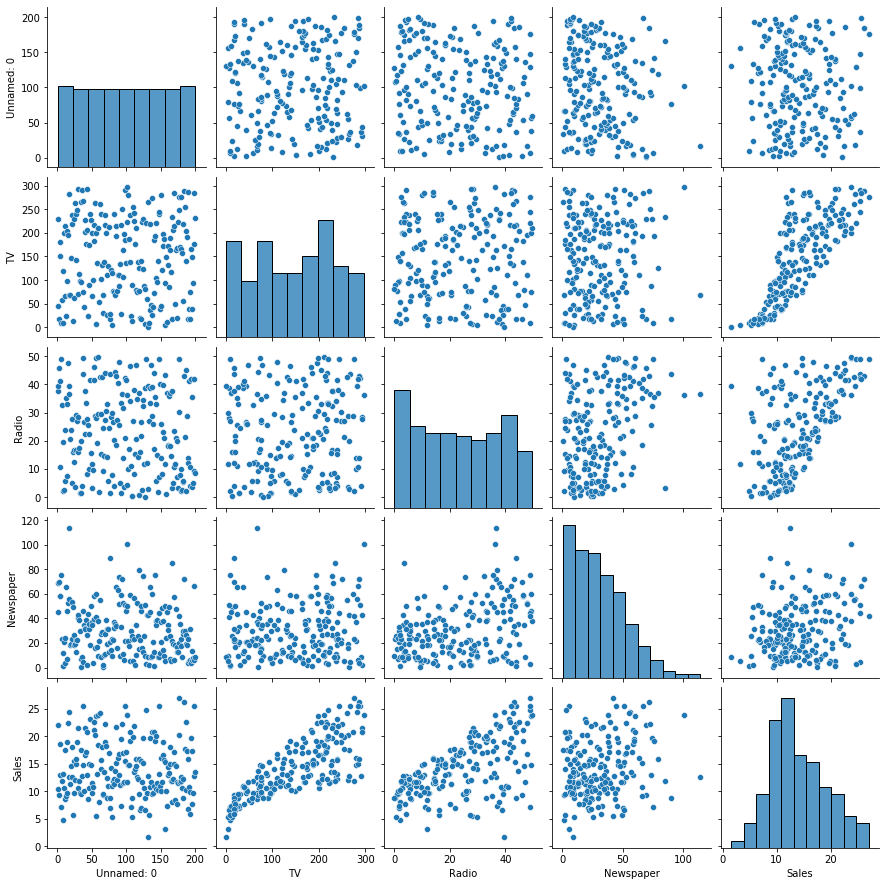

In [5]:
sns.pairplot(df)

In [113]:
X, y = df[['Radio', 'TV']].to_numpy(), df['Sales'].to_numpy().reshape(-1, 1)

X, y = Tensor(X), Tensor(y)

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  2.,  2.,  2.,  0.,  0.,  2.,  2.,  1.,  4.,  2.,  0.,  2.,
         1.,  5.,  2.,  1.,  3., 10.,  1.,  3.,  4.,  6.,  4.,  3.,  6.,
         7.,  8.,  3.,  4.,  3.,  6.,  3.,  4.,  1.,  1.,  2.,  2.,  6.,
         4.,  3.,  3.,  2.,  5.,  1.,  0.,  3.,  2.,  5.,  3.,  0.,  3.,
         1.,  2.,  0.,  4.,  2.,  3.,  2.,  1.,  2.,  0.,  4.,  0.,  2.,
         1.,  2.,  1.,  3.,  2.,  0.,  0.,  1.,  0.,  3.,  1.,  1.,  1.,
         0.,  0.,  3.,  1.,  0.,  1.,  0.,  0.,  1.]),
 array([ 1.6      ,  1.854    ,  2.108    ,  2.362    ,  2.616    ,
         2.8700001,  3.124    ,  3.378    ,  3.632    ,  3.886    ,
         4.14     ,  4.394    ,  4.6480002,  4.902    ,  5.156    ,
         5.41     ,  5.664    ,  5.918    ,  6.172    ,  6.426    ,
         6.68     ,  6.934    ,  7.188    ,  7.442    ,  7.696    ,
         7.95     ,  8.204    ,  8.458    ,  8.712    ,  8.966    ,
         9.22     ,  9.474

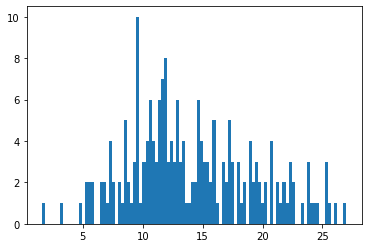

In [114]:
plt.hist(y.T, bins=100)

In [115]:
data = ch.linspace(0, 1500, 100).reshape(100, 1)

gt_ols = LinearRegression()
gt_ols.fit(X, y)
score = gt_ols.score(X, y)
print("r^2: ", score)
gt_var = (y - gt_ols.predict(X)).var(0)
print('ground-truth variance: ', float(gt_var))

r^2:  0.8971942568753976
ground-truth variance:  2.79856276512146


# Now we standardize our empirical data and generate new ols estimates

In [116]:
# random = ch.randn(X.shape[1], 2)
random = ch.eye(X.shape[1])
x_transform = X@random
w_transform = Tensor(gt_ols.coef_)@random

ValueError: x and y must be the same size

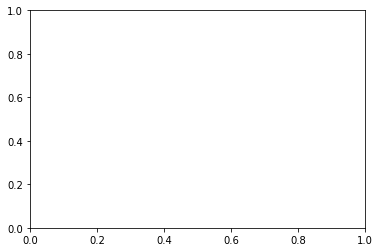

In [117]:
data = ch.linspace(0, 50, 100)[...,None]
plt.scatter(X, y, label='data')
plt.plot(data, gt_ols.predict(data), color='r', label='gt')
plt.xlabel('PT08.S4(NO2)')
plt.ylabel('NO2(GT)')
plt.legend()

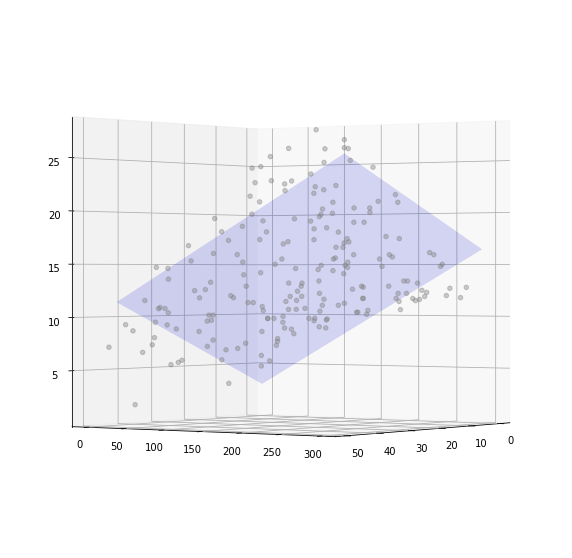

In [118]:
fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')

x_max, x_min = x_transform.max(0)[0], x_transform.min(0)[0]
X_ = np.arange(x_min[0], x_max[0], 5.0)
Y = np.arange(x_min[1], x_max[1], 5.0)
X_, Y = np.meshgrid(X_, Y) 


actual = Tensor([])
for i in range(X_.shape[0]): 
    input_ = Tensor(np.hstack([X_[i].reshape(-1, 1), Y[i].reshape(-1, 1)]))
    actual = ch.cat([actual, input_@w_transform.T + gt_ols.intercept_], 1)
ax.plot_surface(X_, Y, actual.numpy().T, alpha=.15, color='blue')

ax.scatter3D(x_transform[:,0], x_transform[:,1], y, color='grey', label='S', alpha=.4)
ax.view_init(0, 35)

# Truncate Dataset

In [153]:
phi = oracle.Right(15)
indices = phi(y).flatten().nonzero(as_tuple=False).flatten()
x_trunc, y_trunc = X[indices], y[indices]
alpha = x_trunc.size(0) / X.size(0)
print("alpha: ", alpha)

alpha:  0.615


In [154]:
trunc_ols = LinearRegression()
trunc_ols.fit(x_trunc, y_trunc) 
score = trunc_ols.score(X, y)
print("r^2: ", score)
emp_var = (y_trunc - trunc_ols.predict(x_trunc)).var(0)
print('empirical variance: ', float(emp_var))

r^2:  0.7053757138926391
empirical variance:  2.3435206413269043


In [155]:
x_trunc_transform = x_transform[indices]
w = Tensor(trunc_ols.coef_)@random

# Truncate Regression


# Data Preprocessing
We will now use our algorithms to try to correct for this bias.

In [156]:
data = ch.linspace(0, 1.5, 100).reshape(-1, 1)

# scale wind by actual noise variance
y_trunc_mu = y_trunc.mean(0)
y_trunc_scaled = (y_trunc - y_trunc_mu) / ch.sqrt(gt_var)
y_scaled = (y - y_trunc_mu) / ch.sqrt(gt_var)

beta = LA.norm(x_trunc, dim=-1, ord=float('inf')).max()*math.sqrt(X.size(1))
x_trunc_norm = x_trunc / beta
x_norm = X / beta

scaled_ols = LinearRegression()
scaled_ols.fit(x_norm, y_scaled)

trunc_scaled_ols = LinearRegression()
trunc_scaled_ols.fit(x_trunc_norm, y_trunc_scaled)

LinearRegression()

In [157]:
data = ch.linspace(0, 1.5, 100).reshape(-1, 1)

# scale wind by actual noise variance
y_trunc_mu = y_trunc.mean(0)
y_trunc_emp_scaled = (y_trunc - y_trunc_mu) / ch.sqrt(emp_var)
y_emp_scaled = (y - y_trunc_mu) / ch.sqrt(emp_var)

beta = LA.norm(x_trunc, dim=-1, ord=float('inf')).max()*math.sqrt(X.size(1))
x_trunc_norm = x_trunc / beta
x_norm = X / beta

emp_scaled_ols = LinearRegression()
emp_scaled_ols.fit(x_norm, y_emp_scaled)

trunc_emp_scaled_ols = LinearRegression()
trunc_emp_scaled_ols.fit(x_trunc_norm, y_trunc_emp_scaled)

LinearRegression()

ValueError: x and y must be the same size

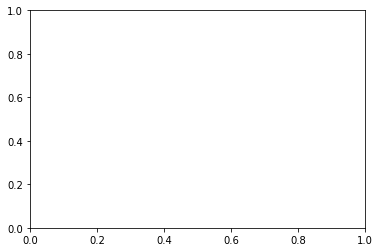

In [158]:
data = ch.linspace(0, 1, 100)[...,None]
plt.scatter(x_trunc_norm, y_trunc_scaled, label='S', color='grey', alpha=.5)
plt.plot(data, scaled_ols.predict(data), color='b', label='gt')
plt.plot(data, trunc_scaled_ols.predict(data), color='r', label='trunc ols')
plt.xlabel('PTO8.S2(NMHC)')
plt.ylabel('CO(GT)')
plt.legend()

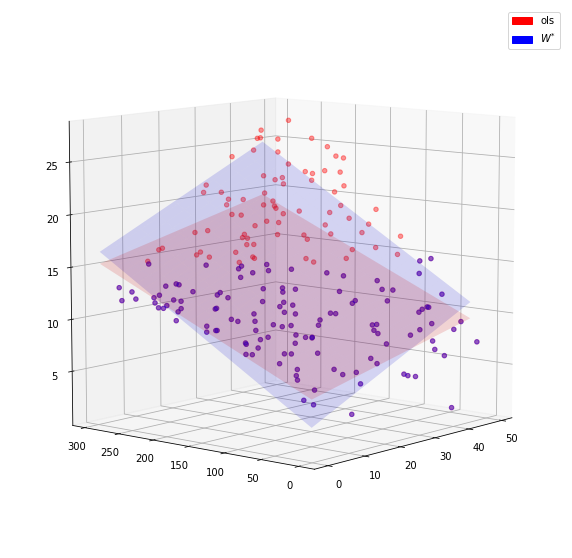

In [159]:
import matplotlib.patches as mpatches

fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')


x_max, x_min = x_transform.max(0)[0], x_transform.min(0)[0]
X_ = np.arange(x_min[0], x_max[0], 5)
Y = np.arange(x_min[1], x_max[1], 5)
X_, Y = np.meshgrid(X_, Y) 

with ch.no_grad():
    emp = Tensor([])
    for i in range(X_.shape[0]): 
        input_ = Tensor(np.hstack([X_[i].reshape(-1, 1), Y[i].reshape(-1, 1)]))
        emp = ch.cat([emp, input_@w.T + trunc_ols.intercept_], 1)
    ax.plot_surface(X_, Y, emp.numpy().T, alpha=.15, color='red')
    
    actual = Tensor([])
    for i in range(X_.shape[0]): 
        input_ = Tensor(np.hstack([X_[i].reshape(-1, 1), Y[i].reshape(-1, 1)]))
        actual = ch.cat([actual, input_@w_transform.T + gt_ols.intercept_], 1)
    ax.plot_surface(X_, Y, actual.numpy().T, alpha=.15, color='blue')
    
ax.scatter3D(x_transform[:,0], x_transform[:,1], y, color='red', label='entire dataset', alpha=.4)
ax.scatter3D(x_trunc_transform[:,0], x_trunc_transform[:,1], y_trunc, color='blue', label='S', alpha=.4)

red_patch = mpatches.Patch(color='red', label='ols')
blue_patch = mpatches.Patch(color='blue', label="$W^{*}$")
plt.legend(handles=[red_patch, blue_patch], loc="upper right")
    
ax.view_init(9.0, 220)

Now, we will our truncated regression algorithm with known variance of the truncated regression data.

In [165]:
scaled_phi = oracle.Right((phi.right - y_trunc_mu) / ch.sqrt(gt_var))
known_trunc_reg = TruncatedRegression(phi=scaled_phi, alpha=Tensor([alpha]), lr=1e-1, unknown=False, bs=1, n=100, tol=1e-2, steps=2500, val=int(.1*y_trunc.size(0)))
known_trunc_reg.fit(x_trunc_norm, y_trunc_scaled)

Iteration 1 | Score: 0.35324716567993164
Iteration 2 | Score: 0.5081353187561035
Iteration 3 | Score: 0.12422432005405426
Iteration 4 | Score: 0.01898980140686035
Iteration 5 | Score: 0.047836706042289734
Iteration 6 | Score: 0.16866689920425415
Final Score: 0.009964522905647755


Linear(in_features=2, out_features=1, bias=True)

In [166]:
known_w, known_w0 = (known_trunc_reg.weight * ch.sqrt(gt_var)) / beta, known_trunc_reg.intercept * ch.sqrt(gt_var) + y_trunc_mu

In [167]:
mse_loss(ch.cat([known_w.flatten(), known_w0]), ch.cat([Tensor(gt_ols.coef_.flatten()), Tensor(gt_ols.intercept_)]))**.5

tensor(1.5746)

In [168]:
mse_loss(ch.cat([Tensor(trunc_ols.coef_.flatten()), Tensor(trunc_ols.intercept_)]), ch.cat([Tensor(gt_ols.coef_.flatten()), Tensor(gt_ols.intercept_)]))**.5






tensor(1.4974)

In [169]:
(y_trunc_scaled - trunc_scaled_ols.predict(x_trunc_norm)).var(0)

tensor([0.8374])

ValueError: x and y must be the same size

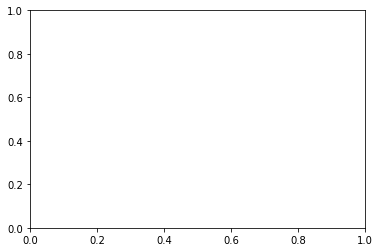

In [131]:
data = ch.linspace(0, 1, 100)[...,None]
plt.scatter(x_trunc_norm, y_trunc_scaled, label='S', color='grey', alpha=.5)
plt.plot(data, scaled_ols.predict(data), color='b', label='gt')
with ch.no_grad():
    plt.plot(data, known_trunc_reg(data), color='g', label='our algorithm')
plt.plot(data, trunc_scaled_ols.predict(data), color='r')
plt.xlabel('PTO8.S2(NMHC)')
plt.ylabel('CO(GT)')
plt.legend()

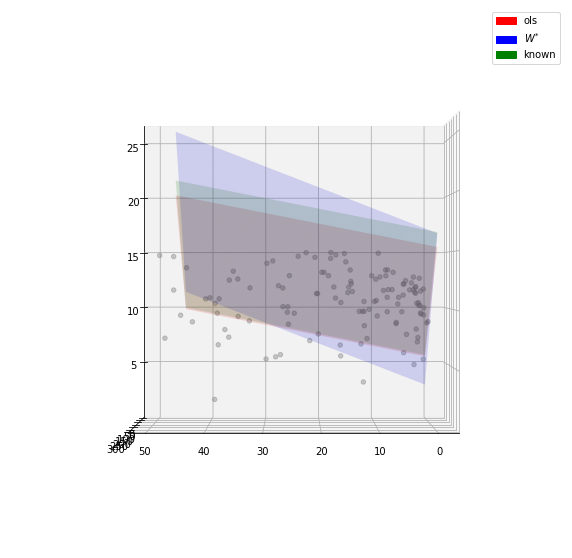

In [171]:
import matplotlib.patches as mpatches

fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')


# ax.scatter3D(x_non_trunc[:,0], x_non_trunc[:,1], y_non_trunc, color='red', label='not seen', alpha=.1)


x_max, x_min = x_transform.max(0)[0], x_transform.min(0)[0]
X_ = np.arange(x_min[0], x_max[0], 5)
Y = np.arange(x_min[1], x_max[1], 5)
X_, Y = np.meshgrid(X_, Y) 

with ch.no_grad():
    emp = Tensor([])
    for i in range(X_.shape[0]): 
        input_ = Tensor(np.hstack([X_[i].reshape(-1, 1), Y[i].reshape(-1, 1)]))
        emp = ch.cat([emp, input_@w.T + trunc_ols.intercept_], 1)
    ax.plot_surface(X_, Y, emp.numpy().T, alpha=.15, color='red')
    
    actual = Tensor([])
    for i in range(X_.shape[0]): 
        input_ = Tensor(np.hstack([X_[i].reshape(-1, 1), Y[i].reshape(-1, 1)]))
        actual = ch.cat([actual, input_@w_transform.T + gt_ols.intercept_], 1)
    ax.plot_surface(X_, Y, actual.numpy().T, alpha=.15, color='blue')
    
    known_w_transform = known_w.T@random
    
    pred = Tensor([])
    for i in range(X_.shape[0]): 
        input_ = Tensor(np.hstack([X_[i].reshape(-1, 1), Y[i].reshape(-1, 1)]))
        pred = ch.cat([pred, input_@known_w_transform.T + known_w0], 1)
    ax.plot_surface(X_, Y, pred.numpy().T, alpha=.15, color='green')

ax.scatter3D(x_trunc_transform[:,0][...,None], x_trunc_transform[:,1][...,None], y_trunc, color='grey', label='S', alpha=.4)

    
red_patch = mpatches.Patch(color='red', label='ols')

green_patch = mpatches.Patch(color='green', label='known')
blue_patch = mpatches.Patch(color='blue', label="$W^{*}$")
plt.legend(handles=[red_patch, blue_patch, green_patch], loc="upper right")
    
ax.view_init(0, 90)

In [192]:
emp_scaled_phi = oracle.Right((phi.right - y_trunc_mu) / ch.sqrt(emp_var))
unknown_trunc_reg = TruncatedRegression(phi=emp_scaled_phi, alpha=Tensor([alpha]), unknown=True, lr=1e-1, step_lr_gamma=.9, bs=10, n=100, tol=1e-2, steps=5000, val=int(.1*y_trunc.size(0)))
unknown_trunc_reg.fit(x_trunc_norm, y_trunc_emp_scaled)

Iteration 1 | Score: 0.7219982743263245
Iteration 2 | Score: 0.4018281102180481
Iteration 3 | Score: 0.6057937741279602
Iteration 4 | Score: 0.6495603919029236
Iteration 5 | Score: 0.570197582244873
Iteration 6 | Score: 0.5383569002151489
Iteration 7 | Score: 0.6576448082923889
Iteration 8 | Score: 0.401482492685318
Iteration 9 | Score: 0.5739133358001709
Iteration 10 | Score: 0.6345232129096985
Iteration 11 | Score: 0.3781265318393707
Iteration 12 | Score: 0.5922611951828003
Iteration 13 | Score: 0.5975846648216248
Iteration 14 | Score: 0.36999818682670593
Iteration 15 | Score: 0.5031033754348755
Iteration 16 | Score: 0.5196076035499573
Iteration 17 | Score: 0.30179768800735474
Iteration 18 | Score: 0.5251137614250183
Iteration 19 | Score: 0.5883610248565674
Iteration 20 | Score: 0.24263033270835876
Iteration 21 | Score: 0.45480427145957947
Iteration 22 | Score: 0.4817267656326294
Iteration 23 | Score: 0.30881592631340027
Iteration 24 | Score: 0.4085286259651184
Iteration 25 | Score: 

LinearUnknownVariance()

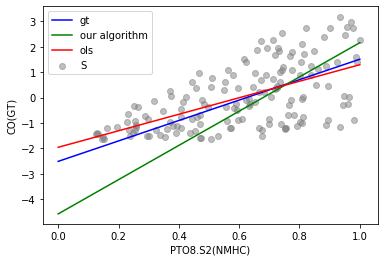

In [49]:
data = ch.linspace(0.0, 1, 100)[...,None]
plt.scatter(x_trunc_norm, y_trunc_emp_scaled, label='S', color='grey', alpha=.5)
plt.plot(data, emp_scaled_ols.predict(data), color='b', label='gt')
with ch.no_grad():
    plt.plot(data, unknown_trunc_reg(data), color='g', label='our algorithm')
plt.plot(data, trunc_emp_scaled_ols.predict(data), color='r', label='ols')
plt.xlabel('PTO8.S2(NMHC)')
plt.ylabel('CO(GT)')
plt.legend()

In [193]:
unknown_w, unknown_w0 = (unknown_trunc_reg.weight * ch.sqrt(emp_var)) / beta, unknown_trunc_reg.intercept * ch.sqrt(emp_var) + y_trunc_mu

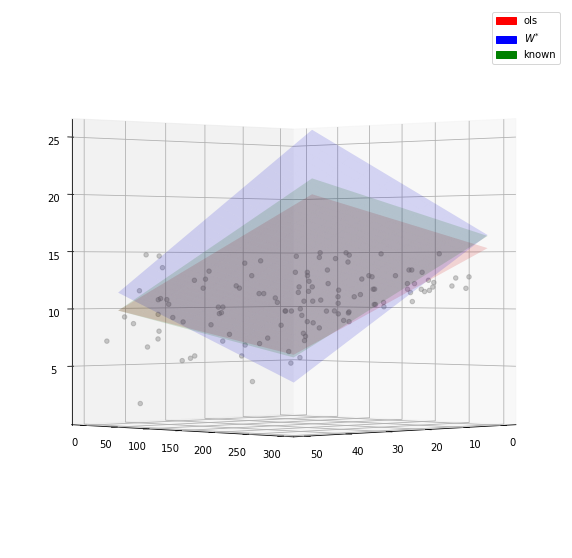

In [198]:
import matplotlib.patches as mpatches

fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')


# ax.scatter3D(x_non_trunc[:,0], x_non_trunc[:,1], y_non_trunc, color='red', label='not seen', alpha=.1)


x_max, x_min = x_transform.max(0)[0], x_transform.min(0)[0]
X_ = np.arange(x_min[0], x_max[0], 5)
Y = np.arange(x_min[1], x_max[1], 5)
X_, Y = np.meshgrid(X_, Y) 

with ch.no_grad():
    emp = Tensor([])
    for i in range(X_.shape[0]): 
        input_ = Tensor(np.hstack([X_[i].reshape(-1, 1), Y[i].reshape(-1, 1)]))
        emp = ch.cat([emp, input_@w.T + trunc_ols.intercept_], 1)
    ax.plot_surface(X_, Y, emp.numpy().T, alpha=.15, color='red')
    
    actual = Tensor([])
    for i in range(X_.shape[0]): 
        input_ = Tensor(np.hstack([X_[i].reshape(-1, 1), Y[i].reshape(-1, 1)]))
        actual = ch.cat([actual, input_@w_transform.T + gt_ols.intercept_], 1)
    ax.plot_surface(X_, Y, actual.numpy().T, alpha=.15, color='blue')
    
    unknown_w_transform = unknown_w.T@random
    
    pred = Tensor([])
    for i in range(X_.shape[0]): 
        input_ = Tensor(np.hstack([X_[i].reshape(-1, 1), Y[i].reshape(-1, 1)]))
        pred = ch.cat([pred, input_@unknown_w_transform.T + unknown_w0], 1)
    ax.plot_surface(X_, Y, pred.numpy().T, alpha=.15, color='green')

ax.scatter3D(x_trunc_transform[:,0][...,None], x_trunc_transform[:,1][...,None], y_trunc, color='grey', label='S', alpha=.4)

    
red_patch = mpatches.Patch(color='red', label='ols')

green_patch = mpatches.Patch(color='green', label='known')
blue_patch = mpatches.Patch(color='blue', label="$W^{*}$")
plt.legend(handles=[red_patch, blue_patch, green_patch], loc="upper right")
    
ax.view_init(0, 45)

In [199]:
unknown_trunc_reg.score()

tensor(0.3970, grad_fn=<CopyBackwards>)

In [200]:
gt_params

tensor([0.1880, 0.0458, 2.9211])

In [184]:
w_, w0_ = (unknown_trunc_reg.weight * ch.sqrt(emp_var)) / beta, unknown_trunc_reg.intercept * ch.sqrt(emp_var) + y_trunc_mu





In [185]:
ch.sqrt(mse_loss(ch.cat([unknown_w.flatten(), unknown_w0.flatten()]), gt_params))

tensor(1.2762)

In [186]:
emp_scaled_ols_params = Tensor(np.concatenate([emp_scaled_ols.coef_.flatten(), emp_scaled_ols.intercept_]))
trunc_emp_scaled_ols_params = Tensor(np.concatenate([trunc_emp_scaled_ols.coef_.flatten(), trunc_emp_scaled_ols.intercept_]))
emp_scaled_unknown_params = Tensor(np.concatenate([unknown_trunc_reg.weight.flatten(), unknown_trunc_reg.intercept.flatten()]))

In [187]:
mse_loss(trunc_emp_scaled_ols_params, emp_scaled_ols_params)**(.5)

tensor(14.4786)

In [188]:
ch.sqrt(mse_loss(Tensor(np.concatenate([trunc_ols.coef_.flatten(), trunc_ols.intercept_])), gt_params))

tensor(1.4974)

In [143]:
gt_params

tensor([0.1880, 0.0458, 2.9211])

In [41]:
Tensor(np.concatenate([trunc_ols.coef_.flatten(), trunc_ols.intercept_]))

tensor([ -0.0691,   0.2112, -22.3853])

In [42]:
unknown_pred = X@unknown_w + unknown_w0

In [43]:
r2_score(y, unknown_pred)

0.5411272624409258

In [44]:
r2_score(y, trunc_ols.predict(X))

0.5411272100269564

In [66]:
r2_score(y, gt_ols.predict(X))

0.5411531520066606

In [100]:
unknown_trunc_reg.variance * emp_var

tensor([[803.4533]])

In [102]:
gt_var

tensor([1033.5864])

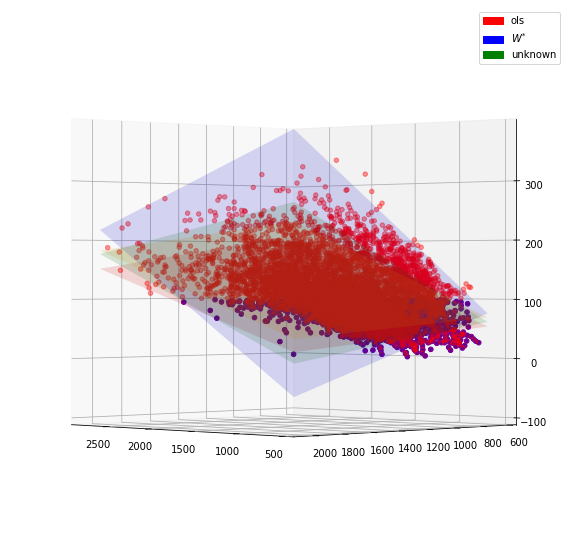

In [67]:
import matplotlib.patches as mpatches

fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')


x_max, x_min = x_transform.max(0)[0], x_transform.min(0)[0]
X_ = np.arange(x_min[0], x_max[0], 1.0)
Y = np.arange(x_min[1], x_max[1], 1.0)
X_, Y = np.meshgrid(X_, Y) 

with ch.no_grad():
    emp = Tensor([])
    for i in range(X_.shape[0]): 
        input_ = Tensor(np.hstack([X_[i].reshape(-1, 1), Y[i].reshape(-1, 1)]))
        emp = ch.cat([emp, input_@w.T + trunc_ols.intercept_], 1)
    ax.plot_surface(X_, Y, emp.numpy().T, alpha=.15, color='red')
    
    actual = Tensor([])
    for i in range(X_.shape[0]): 
        input_ = Tensor(np.hstack([X_[i].reshape(-1, 1), Y[i].reshape(-1, 1)]))
        actual = ch.cat([actual, input_@w_transform.T + gt_ols.intercept_], 1)
    ax.plot_surface(X_, Y, actual.numpy().T, alpha=.15, color='blue')
    
    unknown_w_transform = w_.T@random
    
    pred = Tensor([])
    for i in range(X_.shape[0]): 
        input_ = Tensor(np.hstack([X_[i].reshape(-1, 1), Y[i].reshape(-1, 1)]))
        pred = ch.cat([pred, input_@unknown_w_transform.T + w0_], 1)
    ax.plot_surface(X_, Y, pred.numpy().T, alpha=.15, color='green')
    
    known_pred = Tensor([])
    for i in range(X_.shape[0]): 
        input_ = Tensor(np.hstack([X_[i].reshape(-1, 1), Y[i].reshape(-1, 1)]))
        known_pred = ch.cat([known_pred, input_@known_w_transform.T + known_w0], 1)
    ax.plot_surface(X_, Y, known_pred.numpy().T, alpha=.15, color='orange')

ax.scatter3D(x_transform[:,0], x_transform[:,1], y, color='red', label='entire dataset', alpha=.4)
ax.scatter3D(x_trunc_transform[:,0], x_trunc_transform[:,1], y_trunc, color='blue', label='S', alpha=1.0)
    
red_patch = mpatches.Patch(color='red', label='ols')
orange_patch = mpatches.Patch(color='red', label='known')
green_patch = mpatches.Patch(color='green', label='unknown')
blue_patch = mpatches.Patch(color='blue', label="$W^{*}$")
plt.legend(handles=[red_patch, blue_patch, green_patch], loc="upper right")
    
ax.view_init(0, 135)

In [141]:
unknown_params = ch.cat([w_, w0_]).flatten()
gt_params = Tensor(np.concatenate([gt_ols.coef_.flatten(), gt_ols.intercept_]))
trunc_ols_params = Tensor(np.concatenate([trunc_ols.coef_.flatten(), trunc_ols.intercept_]))
known_params = ch.cat([known_w.flatten(), known_w0.flatten()])

In [142]:
gt_params

tensor([0.1880, 0.0458, 2.9211])

In [175]:
# spawn subprocess to run truncreg experiment
concat = ch.cat([x_trunc, y_trunc], dim=1).numpy()
"""
DATA FORMAT:
    -First n-1 columns are independent variables
    -nth column is dependent variable
"""
concat_df = pd.DataFrame(concat)
concat_df.to_csv(args.out_dir + '/' + TMP_FILE) # save data to csv
"""
Arguments
- c - truncation point (float)
- dir - left or right -> type of truncation (str)
"""
cmd = [COMMAND, PATH2SCRIPT] + [str(phi.left), str(x_trunc.size(1)), 'left', args.out_dir]

# check_output will run the command and store the result
st = datetime.datetime.now()
result = subprocess.check_output(cmd, universal_newlines=True)
trunc_res = Tensor(pd.read_csv(args.out_dir + '/' + RESULT_FILE)['x'].to_numpy())
trunc_reg_params = ch.cat([trunc_res[1:-1].flatten(), trunc_res[0][None,...]])

trunc_reg_pred = X@trunc_reg_params[:-1] + trunc_reg_params[-1]

In [176]:
mse_loss(trunc_reg_params, gt_params)

tensor(2.0296)

# Set up Experiment
For storing the experiment's hyperparameters, we use [cox](https://github.com/MadryLab/cox), MadryLab's light-weight experimental design and analysis framework. 

In [201]:
args = Parameters({
    "bs": 10,
    "trials": 10,
    "steps": 1500,
    "out_dir": '/Users/patroklos/regression', 
    "table_name": 'results', 
    'tol': 1e-2,
    'n': 100,
    'lr': 1e-1,
    'step_lr': 100, 
    'step_lr_gamma': .9,
    'attempts': 3, 
    'val': .1,
})
EXP = 'Advertising_'
mse_loss = ch.nn.MSELoss()

# Create Store for Experiment Results

In [202]:
def run_trial(kwargs, X, y, tol, attempts):
    """
    Runs a trial of a truncated regression experiment. Runs a maximum 
    of three trials of an experiment. The experiment terminates when either 
    the norm of teh score is less than 3e-1, or when three trials is up. After 
    three trials it returns the best truncated regression experiment.
    :param kwargs: keyword arguments for experiment 
    :param X: independent variable
    :param y: dependent variable
    :return: truncated regression experiment and time that experiment took
    """
    st = datetime.datetime.now()        
    # run procedure until get reasonable score
    attempt, score, best_trunc_reg = 0, None, None
    while (score is None or score.norm() > tol) and attempt < attempts:
        trunc_reg = TruncatedRegression(**kwargs)
        trunc_reg.fit(X, y)
        grad = trunc_reg.score()
        if score is None or grad.norm() < score.norm(): 
            score, best_trunc_reg = grad, trunc_reg
        attempt += 1
    total_time = int((datetime.datetime.now() - st).total_seconds())
    return best_trunc_reg, total_time   

# Run Procedure

In [203]:
# ground_truth parameters
gt = LinearRegression() 
gt.fit(X, y)
gt_params = Tensor(np.concatenate([gt.coef_.flatten() ,gt.intercept_]))
gt_var = Tensor(np.var(gt.predict(X) - y.numpy(), 0))
gt_r2 = r2_score(y, gt.predict(X))

C = [25, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10]
for i in range(args.trials):
    # create store
    store = Store(args.out_dir + '/' + EXP)
    store.add_table(TABLE_NAME, { 
        'known_r2': float,
        'known_param_mse': float,
        'known_time': int,
#         'known_unknown_r2': float,
#         'known_unknown_param_mse': float,
#         'known_unknown_time': int,
        'unknown_param_mse': float,
        'unknown_var_l1': float,
        'unknown_r2': float,
        'unknown_time': int,
        'ols_r2': float, 
        'ols_param_mse': float,
        'ols_var_l1': float,
        'trunc_reg_param_mse': float, 
        'trunc_reg_var_l1': float,
        'trunc_reg_r2': float,
        'trunc_reg_time': int,
        'alpha': float, 
        'c': float, 
        'num_samples': int,
    })
    
    for c in C: 
        # truncate
        phi = oracle.Right(c)
        indices = phi(y).flatten().nonzero(as_tuple=False).flatten()
        x_trunc, y_trunc = X[indices], y[indices]
        # add survival probability to hyperparameters
        alpha = Tensor([x_trunc.size(0) / X.size(0)])
        
        y_trunc_mu = y_trunc.mean(0)
        
        # empirical linear regression
        ols = LinearRegression() 
        ols.fit(x_trunc, y_trunc)
        emp_noise_var = ch.var(Tensor(ols.predict(x_trunc)) - y_trunc, dim=0)[...,None]
        ols_params = ch.cat([Tensor(ols.coef_).T, Tensor(ols.intercept_)[..., None]]).flatten()
        print("c: ", c)
        print("emp noise var: ", emp_noise_var)
        print("gt var: ", gt_var)

        # ols results
        store[TABLE_NAME].update_row({
            'ols_r2': r2_score(y.flatten(), ols.predict(X).flatten()), 
            'ols_var_l1': ch.abs(emp_noise_var - gt_var),
            'ols_param_mse': mse_loss(ols_params, gt_params),
        })
        val = int(args.val*x_trunc.size(0))
        
        beta = LA.norm(x_trunc, dim=-1, ord=float('inf')).max()*math.sqrt(X.size(1))
        x_trunc_norm = x_trunc / beta
        
        # scale by the known noise variance 
        y_trunc_scaled = (y_trunc - y_trunc_mu) / ch.sqrt(gt_var)
        phi_scaled = oracle.Right((phi.right - y_trunc_mu) / ch.sqrt(gt_var))
        
        # standardize noised by actual noise variance
        known_kwargs = { 
            'phi': phi_scaled, 
            'alpha': alpha, 
            'bias': args.bias, 
            'unknown': False, 
            'bs': args.bs, 
            'n': args.n, 
            'tol': args.tol, 
            'steps': args.steps, 
            'step_lr': args.step_lr, 
            'step_lr_gamma': args.step_lr_gamma,
            'val': val
            
        }
        
        # truncated linear regression with known noise variance using empirical noise variance
        known_trunc_reg, total_time = run_trial(known_kwargs, x_trunc_norm, y_trunc_scaled, args.tol, args.attempts) 
        
        w, w0 = (known_trunc_reg.weight * ch.sqrt(gt_var)) / beta, known_trunc_reg.intercept * ch.sqrt(gt_var) + y_trunc_mu 
        known_params = ch.cat([w.flatten(), w0])
        # known results
        store[TABLE_NAME].update_row({
            'known_r2': r2_score(y.flatten(), X@w + w0), 
            'known_param_mse': mse_loss(known_params, gt_params),
            'known_time': total_time, 
        })
        
        phi_emp_scaled = oracle.Right((phi.right - y_trunc_mu) / ch.sqrt(emp_noise_var))
        y_trunc_emp_scaled = (y_trunc - y_trunc_mu) / ch.sqrt(emp_noise_var)
            
        # standardize noised by actual noise variance
        unknown_kwargs = { 
            'phi': phi_emp_scaled, 
            'alpha': alpha, 
            'bias': args.bias, 
            'unknown': True, 
            'bs': args.bs, 
            'n': args.n, 
            'tol': args.tol, 
            'steps': args.steps, 
            'step_lr': args.step_lr, 
            'step_lr_gamma': args.step_lr_gamma,
            'val': val
        }
        
        # truncated linear regression with unknown noise variance using empirical noise variance
        trunc_reg, total_time = run_trial(unknown_kwargs, x_trunc_norm, y_trunc_emp_scaled, args.tol, args.attempts)  
        
        w, w0 = (trunc_reg.weight * ch.sqrt(emp_noise_var)) / beta, trunc_reg.intercept * ch.sqrt(emp_noise_var) + y_trunc_mu
        unknown_params = ch.cat([w.flatten(), w0.flatten()])
        # known results
        store[TABLE_NAME].update_row({
            'unknown_r2': r2_score(y.flatten(), X@w + w0), 
            'unknown_param_mse': mse_loss(unknown_params, gt_params),
            'unknown_time': total_time, 
            'unknown_var_l1': ch.abs(trunc_reg.variance * emp_noise_var - gt_var)
        })
            
        # spawn subprocess to run truncreg experiment
        concat = ch.cat([x_trunc, y_trunc], dim=1).numpy()
        """
        DATA FORMAT:
            -First n-1 columns are independent variables
            -nth column is dependent variable
        """
        concat_df = pd.DataFrame(concat)
        concat_df.to_csv(args.out_dir + '/' + TMP_FILE) # save data to csv
        """
        Arguments
        - c - truncation point (float)
        - dir - left or right -> type of truncation (str)
        """
        cmd = [COMMAND, PATH2SCRIPT] + [str(c), str(x_trunc.size(1)), 'right', args.out_dir]

        # check_output will run the command and store the result
        st = datetime.datetime.now()
        result = subprocess.check_output(cmd, universal_newlines=True)
        trunc_res = Tensor(pd.read_csv(args.out_dir + '/' + RESULT_FILE)['x'].to_numpy())
        trunc_reg_params = ch.cat([trunc_res[1:-1].flatten(), trunc_res[0][None,...]])

        trunc_reg_pred = X@trunc_reg_params[:-1] + trunc_reg_params[-1]
        
        # truncreg results
        store[TABLE_NAME].update_row({
            'trunc_reg_r2': r2_score(y.flatten(), trunc_reg_pred.flatten()), 
            'trunc_reg_param_mse': mse_loss(trunc_reg_params, gt_params),
            'trunc_reg_var_l1': ch.abs(trunc_res[-1].pow(2)[None,...] - gt_var),
            'trunc_reg_time': int((datetime.datetime.now() - st).total_seconds()), 
        })   

#         unknown_pred_var = trunc_reg.variance * emp_noise_var
        
#         phi_known_unknown_scaled = oracle.Right((phi.right - y_trunc_mu) / ch.sqrt(unknown_pred_var))
        
#         # standardize noised by actual noise variance
#         known_kwargs = { 
#             'phi': phi_known_unknown_scaled, 
#             'alpha': alpha, 
#             'bias': args.bias, 
#             'unknown': False, 
#             'bs': args.bs, 
#             'n': args.n, 
#             'tol': args.tol, 
#             'steps': args.steps, 
#             'step_lr': args.step_lr, 
#             'step_lr_gamma': args.step_lr_gamma,
#             'val': val
            
#         }
        
#         # truncated linear regression with known noise variance using empirical noise variance
#         unknown_known_trunc_reg, total_time = run_trial(known_kwargs, x_trunc_norm, y_trunc_scaled, args.tol, args.attempts) 
        
#         w, w0 = (unknown_known_trunc_reg.weight * ch.sqrt(unknown_pred_var)) / beta, unknown_known_trunc_reg.intercept * ch.sqrt(unknown_pred_var) + y_trunc_mu 
#         known_unknown_params = ch.cat([w.flatten(), w0.flatten()])
#         # known results
#         store[TABLE_NAME].update_row({
#             'known_unknown_r2': r2_score(y.flatten(), X@w + w0), 
#             'known_unknown_param_mse': mse_loss(known_unknown_params, gt_params),
#             'known_unknown_time': total_time, 
#         })
        
        
        
        store[TABLE_NAME].append_row({ 
            'alpha': float(alpha), 
            'c': c,    
            'num_samples': x_trunc.size(0),
        })
            
    # close current store
    store.close()

Logging in: /Users/patroklos/regression/Advertising_/9443475d-dcb2-4af2-aeda-5faa63aeb446
c:  25
emp noise var:  tensor([[2.7496]])
gt var:  tensor([2.7846])
Iteration 1 | Score: 0.15696902573108673
Iteration 2 | Score: 0.15594449639320374
Iteration 3 | Score: 0.16952678561210632
Iteration 4 | Score: 0.16274169087409973
Iteration 5 | Score: 0.19520863890647888
Iteration 6 | Score: 0.13115230202674866
Iteration 7 | Score: 0.21635660529136658
Iteration 8 | Score: 0.1396918147802353
Iteration 9 | Score: 0.17092011868953705
Iteration 10 | Score: 0.14225734770298004
Iteration 11 | Score: 0.1858474612236023
Iteration 12 | Score: 0.13878120481967926
Iteration 13 | Score: 0.18338154256343842
Iteration 14 | Score: 0.1342325657606125
Iteration 15 | Score: 0.11494618654251099
Iteration 1 | Score: 0.41286084055900574
Iteration 2 | Score: 0.3575736880302429
Iteration 3 | Score: 0.33189451694488525
Iteration 4 | Score: 0.2993786931037903
Iteration 5 | Score: 0.3804995119571686
Iteration 6 | Score: 0

Iteration 5 | Score: 0.0703544169664383
Iteration 6 | Score: 0.1188945472240448
Iteration 7 | Score: 0.157475546002388
Iteration 8 | Score: 0.14645856618881226
Iteration 9 | Score: 0.0832124799489975
Iteration 10 | Score: 0.10618624091148376
Iteration 11 | Score: 0.13812458515167236
Iteration 12 | Score: 0.09832337498664856
Iteration 13 | Score: 0.09871994704008102
Iteration 14 | Score: 0.10989037901163101
Iteration 15 | Score: 0.1306060552597046
Iteration 1 | Score: 0.2955980598926544
Iteration 2 | Score: 0.2809596657752991
Iteration 3 | Score: 0.32715746760368347
Iteration 4 | Score: 0.3164808750152588
Iteration 5 | Score: 0.2779040038585663
Iteration 6 | Score: 0.32906708121299744
Iteration 7 | Score: 0.3030235767364502
Iteration 8 | Score: 0.2998565137386322
Iteration 9 | Score: 0.37800362706184387
Iteration 10 | Score: 0.30824577808380127
Iteration 11 | Score: 0.29106655716896057
Iteration 12 | Score: 0.3836008608341217
Iteration 13 | Score: 0.30819034576416016
Iteration 14 | Scor

Iteration 10 | Score: 0.3393338620662689
Iteration 11 | Score: 0.3228996694087982
Iteration 12 | Score: 0.37126094102859497
Iteration 13 | Score: 0.36404722929000854
Iteration 14 | Score: 0.3410434126853943
Iteration 15 | Score: 0.3516611158847809
Iteration 1 | Score: 0.22750216722488403
Iteration 2 | Score: 0.8422974348068237
Iteration 3 | Score: 0.31762853264808655
Iteration 4 | Score: 0.21816906332969666
Iteration 5 | Score: 0.23481673002243042
Iteration 6 | Score: 0.438888281583786
Iteration 7 | Score: 0.2471366971731186
Iteration 8 | Score: 0.22477339208126068
Iteration 9 | Score: 0.18671225011348724
Iteration 10 | Score: 0.2219681292772293
Iteration 11 | Score: 0.1860208511352539
Iteration 12 | Score: 0.451334148645401
Iteration 13 | Score: 0.19598953425884247
Iteration 14 | Score: 0.18024708330631256
Iteration 15 | Score: 0.41597893834114075
Iteration 1 | Score: 2.167645215988159
Iteration 2 | Score: 2.2177963256835938
Iteration 3 | Score: 1.9914363622665405
Iteration 4 | Score:

Iteration 7 | Score: 0.5334790349006653
Iteration 8 | Score: 0.6019556522369385
Iteration 9 | Score: 0.48819512128829956
Iteration 10 | Score: 0.5496079921722412
Iteration 11 | Score: 0.571587860584259
Iteration 12 | Score: 0.4549297094345093
Iteration 13 | Score: 0.5730016231536865
Iteration 14 | Score: 0.5608471632003784
Iteration 15 | Score: 0.4501363933086395
c:  14
emp noise var:  tensor([[2.2290]])
gt var:  tensor([2.7846])
Iteration 1 | Score: 0.27107787132263184
Iteration 2 | Score: 0.3015546500682831
Iteration 3 | Score: 0.360725998878479
Iteration 4 | Score: 0.3099346458911896
Iteration 5 | Score: 0.33619925379753113
Iteration 6 | Score: 0.29203036427497864
Iteration 7 | Score: 0.24827361106872559
Iteration 8 | Score: 0.3048771619796753
Iteration 9 | Score: 0.2810162603855133
Iteration 10 | Score: 0.29306328296661377
Iteration 11 | Score: 0.3211451470851898
Iteration 12 | Score: 0.3128679096698761
Iteration 13 | Score: 0.2730363607406616
Iteration 14 | Score: 0.26170900464057

Iteration 2 | Score: 0.338030070066452
Iteration 3 | Score: 0.8947814702987671
Iteration 4 | Score: 0.40475159883499146
Iteration 5 | Score: 1.2338348627090454
Iteration 6 | Score: 0.3518596887588501
Iteration 7 | Score: 1.215895652770996
Iteration 8 | Score: 0.4701020121574402
Iteration 9 | Score: 0.8653746247291565
Iteration 10 | Score: 0.25967076420783997
Iteration 11 | Score: 0.8500645756721497
Iteration 12 | Score: 0.23804005980491638
Iteration 13 | Score: 0.7805560231208801
Iteration 14 | Score: 0.3345128893852234
Iteration 15 | Score: 0.9237125515937805
Iteration 1 | Score: 0.10455472767353058
Iteration 2 | Score: 0.24995149672031403
Iteration 3 | Score: 0.4129560887813568
Iteration 4 | Score: 0.4632803201675415
Iteration 5 | Score: 0.37307947874069214
Iteration 6 | Score: 0.559650182723999
Iteration 7 | Score: 0.10667762160301208
Iteration 8 | Score: 0.4065104126930237
Iteration 9 | Score: 0.16027411818504333
Iteration 10 | Score: 0.4184616506099701
Iteration 11 | Score: 0.1276

Iteration 11 | Score: 0.45809033513069153
Iteration 12 | Score: 0.419554203748703
Iteration 13 | Score: 0.28619277477264404
Iteration 14 | Score: 0.7783127427101135
Iteration 15 | Score: 0.41081443428993225
Iteration 1 | Score: 0.6822399497032166
Iteration 2 | Score: 0.6614691019058228
Iteration 3 | Score: 0.7918621897697449
Iteration 4 | Score: 0.5747527480125427
Iteration 5 | Score: 0.6019474864006042
Iteration 6 | Score: 0.4189983308315277
Iteration 7 | Score: 0.39197373390197754
Iteration 8 | Score: 0.47991621494293213
Iteration 9 | Score: 0.5090954303741455
Iteration 10 | Score: 0.4750838577747345
Iteration 11 | Score: 0.485536128282547
Iteration 12 | Score: 0.5348787307739258
Iteration 13 | Score: 0.4363754987716675
Iteration 14 | Score: 0.5120426416397095
Iteration 15 | Score: 0.5752871632575989
Logging in: /Users/patroklos/regression/Advertising_/a4864043-58ac-427c-a0ab-59e444e8a0de
c:  25
emp noise var:  tensor([[2.7496]])
gt var:  tensor([2.7846])
Iteration 1 | Score: 0.13610

Iteration 12 | Score: 0.9683817625045776
Iteration 13 | Score: 0.20833615958690643
Iteration 14 | Score: 0.6520723700523376
Iteration 15 | Score: 1.0859992504119873
c:  18
emp noise var:  tensor([[2.4434]])
gt var:  tensor([2.7846])
Iteration 1 | Score: 0.4734869599342346
Iteration 2 | Score: 0.3812194764614105
Iteration 3 | Score: 0.4174504280090332
Iteration 4 | Score: 0.4017221927642822
Iteration 5 | Score: 0.40641093254089355
Iteration 6 | Score: 0.36550673842430115
Iteration 7 | Score: 0.41197192668914795
Iteration 8 | Score: 0.4220370650291443
Iteration 9 | Score: 0.4322321116924286
Iteration 10 | Score: 0.39922648668289185
Iteration 11 | Score: 0.38116177916526794
Iteration 12 | Score: 0.35663431882858276
Iteration 13 | Score: 0.38290172815322876
Iteration 14 | Score: 0.3424740433692932
Iteration 15 | Score: 0.4469708800315857
Iteration 1 | Score: 0.4582839012145996
Iteration 2 | Score: 0.3382508158683777
Iteration 3 | Score: 0.34777379035949707
Iteration 4 | Score: 0.3756771683

Iteration 1 | Score: 0.5061407685279846
Iteration 2 | Score: 0.5156754851341248
Iteration 3 | Score: 0.531337320804596
Iteration 4 | Score: 0.5029263496398926
Iteration 5 | Score: 0.5160994529724121
Iteration 6 | Score: 0.5406423211097717
Iteration 7 | Score: 0.46269625425338745
Iteration 8 | Score: 0.5636427402496338
Iteration 9 | Score: 0.4519403874874115
Iteration 10 | Score: 0.46862033009529114
Iteration 11 | Score: 0.5050000548362732
Iteration 12 | Score: 0.49545589089393616
Iteration 13 | Score: 0.5154528021812439
Iteration 14 | Score: 0.4721863865852356
Iteration 15 | Score: 0.5408637523651123
Iteration 1 | Score: 0.02580835670232773
Iteration 2 | Score: 0.03445495665073395
Iteration 3 | Score: 0.03045639395713806
Iteration 4 | Score: 0.01304580271244049
Final Score: 0.002344556152820587
Iteration 1 | Score: 1.8297746181488037
Iteration 2 | Score: 1.95248544216156
Iteration 3 | Score: 1.6206401586532593
Iteration 4 | Score: 1.6727049350738525
Iteration 5 | Score: 1.9658865928649

Iteration 10 | Score: 0.20457756519317627
Iteration 11 | Score: 0.18012933433055878
Iteration 12 | Score: 0.18510594964027405
Iteration 13 | Score: 0.16590705513954163
Iteration 14 | Score: 0.1631072461605072
Iteration 15 | Score: 0.17646291851997375
c:  13
emp noise var:  tensor([[2.1705]])
gt var:  tensor([2.7846])
Iteration 1 | Score: 0.4941287338733673
Iteration 2 | Score: 0.5001633167266846
Iteration 3 | Score: 0.4414829909801483
Iteration 4 | Score: 0.37143346667289734
Iteration 5 | Score: 0.3851798474788666
Iteration 6 | Score: 0.46798500418663025
Iteration 7 | Score: 0.37661048769950867
Iteration 8 | Score: 0.408812016248703
Iteration 9 | Score: 0.42961814999580383
Iteration 10 | Score: 0.3814433217048645
Iteration 11 | Score: 0.39340654015541077
Iteration 12 | Score: 0.35445964336395264
Iteration 13 | Score: 0.3334103226661682
Iteration 14 | Score: 0.3753880560398102
Iteration 15 | Score: 0.3176977336406708
Iteration 1 | Score: 0.1891900599002838
Iteration 2 | Score: 0.1486648

Iteration 3 | Score: 0.5579337477684021
Iteration 4 | Score: 0.6038644313812256
Iteration 5 | Score: 0.6409479379653931
Iteration 6 | Score: 0.6095616817474365
Iteration 7 | Score: 0.5810602903366089
Iteration 8 | Score: 0.5857668519020081
Iteration 9 | Score: 0.5414101481437683
Iteration 10 | Score: 0.6230261921882629
Iteration 11 | Score: 0.6227218508720398
Iteration 12 | Score: 0.5058267712593079
Iteration 13 | Score: 0.5113874673843384
Iteration 14 | Score: 0.6028597354888916
Iteration 15 | Score: 0.5935161709785461
Iteration 1 | Score: 0.6228110790252686
Iteration 2 | Score: 0.37656834721565247
Iteration 3 | Score: 0.618473470211029
Iteration 4 | Score: 0.5718119740486145
Iteration 5 | Score: 0.37855687737464905
Iteration 6 | Score: 0.5664845108985901
Iteration 7 | Score: 0.5874742269515991
Iteration 8 | Score: 0.5511992573738098
Iteration 9 | Score: 0.5404382944107056
Iteration 10 | Score: 0.4146982431411743
Iteration 11 | Score: 0.5741207599639893
Iteration 12 | Score: 0.5146264

Iteration 6 | Score: 0.4731577932834625
Iteration 7 | Score: 0.4509415626525879
Iteration 8 | Score: 0.736630916595459
Iteration 9 | Score: 0.2401743084192276
Iteration 10 | Score: 1.5132287740707397
Iteration 11 | Score: 0.5271084308624268
Iteration 12 | Score: 0.9682096242904663
Iteration 13 | Score: 0.7195929884910583
Iteration 14 | Score: 0.2809026539325714
Iteration 15 | Score: 0.5303153991699219
Iteration 1 | Score: 0.979506254196167
Iteration 2 | Score: 0.5140836238861084
Iteration 3 | Score: 0.4156361222267151
Iteration 4 | Score: 0.4194009006023407
Iteration 5 | Score: 0.2343989759683609
Iteration 6 | Score: 0.3125409185886383
Iteration 7 | Score: 0.6325660943984985
Iteration 8 | Score: 0.23840562999248505
Iteration 9 | Score: 0.984835684299469
Iteration 10 | Score: 0.7553176283836365
Iteration 11 | Score: 0.5456046462059021
Iteration 12 | Score: 0.5175395607948303
Iteration 13 | Score: 0.29527154564857483
Iteration 14 | Score: 0.32247599959373474
Iteration 15 | Score: 0.43010

Iteration 11 | Score: 1.9794502258300781
Iteration 12 | Score: 2.1888184547424316
Iteration 13 | Score: 2.3787591457366943
Iteration 14 | Score: 1.939497947692871
Iteration 15 | Score: 2.3089311122894287
c:  18
emp noise var:  tensor([[2.4434]])
gt var:  tensor([2.7846])
Iteration 1 | Score: 0.11998631060123444
Iteration 2 | Score: 0.10373954474925995
Iteration 3 | Score: 0.05143794044852257
Iteration 4 | Score: 0.0745910108089447
Iteration 5 | Score: 0.06240472197532654
Iteration 6 | Score: 0.14785920083522797
Iteration 7 | Score: 0.1198774203658104
Iteration 8 | Score: 0.13812585175037384
Iteration 9 | Score: 0.13438566029071808
Iteration 10 | Score: 0.08660810440778732
Iteration 11 | Score: 0.08850456774234772
Iteration 12 | Score: 0.09824986010789871
Iteration 13 | Score: 0.11007654666900635
Iteration 14 | Score: 0.10308774560689926
Iteration 15 | Score: 0.07553623616695404
Iteration 1 | Score: 0.6012395620346069
Iteration 2 | Score: 0.5814187526702881
Iteration 3 | Score: 0.644754

Iteration 1 | Score: 0.5664774179458618
Iteration 2 | Score: 0.5927553176879883
Iteration 3 | Score: 0.6233150959014893
Iteration 4 | Score: 0.6756126880645752
Iteration 5 | Score: 0.639857828617096
Iteration 6 | Score: 0.6099904179573059
Iteration 7 | Score: 0.6341919302940369
Iteration 8 | Score: 0.575014591217041
Iteration 9 | Score: 0.6041581034660339
Iteration 10 | Score: 0.6576843857765198
Iteration 11 | Score: 0.6101832389831543
Iteration 12 | Score: 0.6047673225402832
Iteration 13 | Score: 0.5723706483840942
Iteration 14 | Score: 0.6045931577682495
Iteration 15 | Score: 0.6060566902160645
Iteration 1 | Score: 0.20388370752334595
Iteration 2 | Score: 0.45154011249542236
Iteration 3 | Score: 0.9180794954299927
Iteration 4 | Score: 0.19272509217262268
Iteration 5 | Score: 0.44446811079978943
Iteration 6 | Score: 0.446433961391449
Iteration 7 | Score: 0.6584435701370239
Iteration 8 | Score: 0.2797066271305084
Iteration 9 | Score: 0.661700963973999
Iteration 10 | Score: 0.3248201310

Iteration 5 | Score: 0.27504613995552063
Iteration 6 | Score: 0.18756885826587677
Iteration 7 | Score: 0.26760637760162354
Iteration 8 | Score: 0.2512616515159607
Iteration 9 | Score: 0.2465887814760208
Iteration 10 | Score: 0.2781378924846649
Iteration 11 | Score: 0.24280749261379242
Iteration 12 | Score: 0.22620758414268494
Iteration 13 | Score: 0.21486100554466248
Iteration 14 | Score: 0.23658791184425354
Iteration 15 | Score: 0.2964003384113312
Iteration 1 | Score: 0.34795132279396057
Iteration 2 | Score: 0.42933332920074463
Iteration 3 | Score: 0.4271681606769562
Iteration 4 | Score: 0.3634159564971924
Iteration 5 | Score: 0.44535335898399353
Iteration 6 | Score: 0.3697229027748108
Iteration 7 | Score: 0.45365002751350403
Iteration 8 | Score: 0.42008015513420105
Iteration 9 | Score: 0.4194313585758209
Iteration 10 | Score: 0.4069896340370178
Iteration 11 | Score: 0.46838968992233276
Iteration 12 | Score: 0.4680241048336029
Iteration 13 | Score: 0.4437921345233917
Iteration 14 | Sc

Iteration 12 | Score: 0.7894216179847717
Iteration 13 | Score: 0.484394907951355
Iteration 14 | Score: 0.7967572808265686
Iteration 15 | Score: 0.3138658106327057
c:  11
emp noise var:  tensor([[1.8086]])
gt var:  tensor([2.7846])
Iteration 1 | Score: 0.05930301174521446
Final Score: 0.004562677349895239
Iteration 1 | Score: 0.11641284823417664
Iteration 2 | Score: 0.01754174381494522
Iteration 3 | Score: 0.07612095028162003
Iteration 4 | Score: 0.1376582384109497
Iteration 5 | Score: 0.10993462800979614
Iteration 6 | Score: 0.12976165115833282
Iteration 7 | Score: 0.0478195995092392
Iteration 8 | Score: 0.07704107463359833
Iteration 9 | Score: 0.16884413361549377
Iteration 10 | Score: 0.07056431472301483
Iteration 11 | Score: 0.06238403171300888
Iteration 12 | Score: 0.13228029012680054
Iteration 13 | Score: 0.09377828985452652
Iteration 14 | Score: 0.12388289719820023
Iteration 15 | Score: 0.1043887659907341
Iteration 1 | Score: 0.13081958889961243
Iteration 2 | Score: 0.172093778848

Iteration 10 | Score: 0.05774207413196564
Iteration 11 | Score: 0.1911127120256424
Iteration 12 | Score: 0.07339317351579666
Iteration 13 | Score: 0.22647392749786377
Iteration 14 | Score: 0.15260976552963257
Iteration 15 | Score: 0.13232861459255219
Iteration 1 | Score: 1.5588289499282837
Iteration 2 | Score: 1.5620802640914917
Iteration 3 | Score: 1.4556041955947876
Iteration 4 | Score: 1.1186188459396362
Iteration 5 | Score: 0.808626651763916
Iteration 6 | Score: 1.2712843418121338
Iteration 7 | Score: 1.1144704818725586
Iteration 8 | Score: 1.0156692266464233
Iteration 9 | Score: 1.4319374561309814
Iteration 10 | Score: 1.3856176137924194
Iteration 11 | Score: 1.4432406425476074
Iteration 12 | Score: 1.2794334888458252
Iteration 13 | Score: 1.0991578102111816
Iteration 14 | Score: 1.078162670135498
Iteration 15 | Score: 1.254622220993042
Iteration 1 | Score: 0.754091739654541
Iteration 2 | Score: 0.5986461043357849
Iteration 3 | Score: 0.4192427396774292
Iteration 4 | Score: 0.3214

Iteration 15 | Score: 0.4328252077102661
Iteration 1 | Score: 0.21900403499603271
Iteration 2 | Score: 0.12067214399576187
Iteration 3 | Score: 0.34986692667007446
Iteration 4 | Score: 0.23497024178504944
Iteration 5 | Score: 0.15825793147087097
Iteration 6 | Score: 0.34987160563468933
Iteration 7 | Score: 0.19939446449279785
Iteration 8 | Score: 0.26031607389450073
Iteration 9 | Score: 0.27819663286209106
Iteration 10 | Score: 0.22411662340164185
Iteration 11 | Score: 0.24816974997520447
Iteration 12 | Score: 0.2740016281604767
Iteration 13 | Score: 0.27006208896636963
Iteration 14 | Score: 0.22753871977329254
Iteration 15 | Score: 0.3458630442619324
c:  18
emp noise var:  tensor([[2.4434]])
gt var:  tensor([2.7846])
Iteration 1 | Score: 0.17599499225616455
Iteration 2 | Score: 0.25078824162483215
Iteration 3 | Score: 0.24264279007911682
Iteration 4 | Score: 0.27971896529197693
Iteration 5 | Score: 0.26082727313041687
Iteration 6 | Score: 0.2655593752861023
Iteration 7 | Score: 0.3118

Iteration 8 | Score: 0.23958073556423187
Iteration 9 | Score: 0.2521247863769531
Iteration 10 | Score: 0.2144637554883957
Iteration 11 | Score: 0.3029230535030365
Iteration 12 | Score: 0.276009202003479
Iteration 13 | Score: 0.2244211733341217
Iteration 14 | Score: 0.2130752056837082
Iteration 15 | Score: 0.33483749628067017
Iteration 1 | Score: 0.2104904055595398
Iteration 2 | Score: 0.14841164648532867
Iteration 3 | Score: 0.16512295603752136
Iteration 4 | Score: 0.1785249561071396
Iteration 5 | Score: 0.2030169665813446
Iteration 6 | Score: 0.1707974672317505
Iteration 7 | Score: 0.1194140762090683
Iteration 8 | Score: 0.18015295267105103
Iteration 9 | Score: 0.21241405606269836
Iteration 10 | Score: 0.18252795934677124
Iteration 11 | Score: 0.22096320986747742
Iteration 12 | Score: 0.18058231472969055
Iteration 13 | Score: 0.16084980964660645
Iteration 14 | Score: 0.21367718279361725
Iteration 15 | Score: 0.2333761751651764
Iteration 1 | Score: 0.157516747713089
Iteration 2 | Score

Iteration 13 | Score: 0.23314161598682404
Iteration 14 | Score: 0.2328093945980072
Iteration 15 | Score: 0.24345268309116364
Iteration 1 | Score: 0.25266915559768677
Iteration 2 | Score: 0.2503052055835724
Iteration 3 | Score: 0.2665373980998993
Iteration 4 | Score: 0.25418025255203247
Iteration 5 | Score: 0.2774488627910614
Iteration 6 | Score: 0.2900939881801605
Iteration 7 | Score: 0.2752086818218231
Iteration 8 | Score: 0.22351139783859253
Iteration 9 | Score: 0.2695801258087158
Iteration 10 | Score: 0.2594220042228699
Iteration 11 | Score: 0.2461601346731186
Iteration 12 | Score: 0.2618542015552521
Iteration 13 | Score: 0.26838356256484985
Iteration 14 | Score: 0.3016272783279419
Iteration 15 | Score: 0.2841276228427887
Iteration 1 | Score: 0.45510974526405334
Iteration 2 | Score: 0.4305160641670227
Iteration 3 | Score: 0.4257456958293915
Iteration 4 | Score: 0.4203146994113922
Iteration 5 | Score: 0.5141087770462036
Iteration 6 | Score: 0.5085335373878479
Iteration 7 | Score: 0.4

Iteration 2 | Score: 2.070061206817627
Iteration 3 | Score: 1.925559639930725
Iteration 4 | Score: 2.0099706649780273
Iteration 5 | Score: 2.0031676292419434
Iteration 6 | Score: 1.8890589475631714
Iteration 7 | Score: 1.8731791973114014
Iteration 8 | Score: 1.9627081155776978
Iteration 9 | Score: 1.9400920867919922
Iteration 10 | Score: 2.0255391597747803
Iteration 11 | Score: 1.883575439453125
Iteration 12 | Score: 2.0426204204559326
Iteration 13 | Score: 2.017585277557373
Iteration 14 | Score: 2.0080294609069824
Iteration 15 | Score: 1.9768567085266113
Iteration 1 | Score: 0.27043408155441284
Iteration 2 | Score: 0.3353874683380127
Iteration 3 | Score: 0.3984891176223755
Iteration 4 | Score: 0.3574269413948059
Iteration 5 | Score: 0.2704547941684723
Iteration 6 | Score: 0.5503597259521484
Iteration 7 | Score: 0.35212090611457825
Iteration 8 | Score: 0.5861983299255371
Iteration 9 | Score: 0.29600733518600464
Iteration 10 | Score: 0.40466704964637756
Iteration 11 | Score: 0.362585186

Iteration 4 | Score: 0.5943483710289001
Iteration 5 | Score: 0.6294981241226196
Iteration 6 | Score: 0.5474271178245544
Iteration 7 | Score: 0.525108814239502
Iteration 8 | Score: 0.5423257350921631
Iteration 9 | Score: 0.526286780834198
Iteration 10 | Score: 0.566779375076294
Iteration 11 | Score: 0.6004135012626648
Iteration 12 | Score: 0.5897681713104248
Iteration 13 | Score: 0.5723558664321899
Iteration 14 | Score: 0.5528669357299805
Iteration 15 | Score: 0.5687023401260376
Iteration 1 | Score: 0.05707584694027901
Iteration 2 | Score: 0.017547234892845154
Iteration 3 | Score: 0.08353038132190704
Iteration 4 | Score: 0.038824114948511124
Final Score: 0.008356742560863495
Iteration 1 | Score: 1.5861001014709473
Iteration 2 | Score: 0.7117370963096619
Iteration 3 | Score: 0.8098764419555664
Iteration 4 | Score: 0.24934405088424683
Iteration 5 | Score: 0.822335422039032
Iteration 6 | Score: 0.6339769959449768
Iteration 7 | Score: 0.7866770625114441
Iteration 8 | Score: 1.30754351615905

Iteration 2 | Score: 0.6834878325462341
Iteration 3 | Score: 0.2991012632846832
Iteration 4 | Score: 0.8373987078666687
Iteration 5 | Score: 0.6863098740577698
Iteration 6 | Score: 0.4690108299255371
Iteration 7 | Score: 0.759459376335144
Iteration 8 | Score: 0.7904612421989441
Iteration 9 | Score: 0.43206337094306946
Iteration 10 | Score: 0.777444064617157
Iteration 11 | Score: 0.7062252163887024
Iteration 12 | Score: 0.3523837924003601
Iteration 13 | Score: 0.7212794423103333
Iteration 14 | Score: 0.6412288546562195
Iteration 15 | Score: 0.43866559863090515
c:  18
emp noise var:  tensor([[2.4434]])
gt var:  tensor([2.7846])
Iteration 1 | Score: 0.2070033848285675
Iteration 2 | Score: 0.22048121690750122
Iteration 3 | Score: 0.2873782217502594
Iteration 4 | Score: 0.2753698229789734
Iteration 5 | Score: 0.23098675906658173
Iteration 6 | Score: 0.2510398328304291
Iteration 7 | Score: 0.34133315086364746
Iteration 8 | Score: 0.17405478656291962
Iteration 9 | Score: 0.23292669653892517
I

Iteration 13 | Score: 0.15310168266296387
Iteration 14 | Score: 0.15993019938468933
Iteration 15 | Score: 0.1749885231256485
Iteration 1 | Score: 0.5134067535400391
Iteration 2 | Score: 0.4619978666305542
Iteration 3 | Score: 0.5105603337287903
Iteration 4 | Score: 0.40307843685150146
Iteration 5 | Score: 0.44634532928466797
Iteration 6 | Score: 0.477699339389801
Iteration 7 | Score: 0.4468298554420471
Iteration 8 | Score: 0.44470512866973877
Iteration 9 | Score: 0.4558661878108978
Iteration 10 | Score: 0.45181265473365784
Iteration 11 | Score: 0.40134501457214355
Iteration 12 | Score: 0.464119553565979
Iteration 13 | Score: 0.4817884862422943
Iteration 14 | Score: 0.4627436399459839
Iteration 15 | Score: 0.44667157530784607
Iteration 1 | Score: 0.5818697810173035
Iteration 2 | Score: 0.5092520117759705
Iteration 3 | Score: 0.5792341828346252
Iteration 4 | Score: 0.5729923844337463
Iteration 5 | Score: 0.5056564211845398
Iteration 6 | Score: 0.5570734739303589
Iteration 7 | Score: 0.44

Iteration 12 | Score: 0.39111196994781494
Iteration 13 | Score: 0.3783824145793915
Iteration 14 | Score: 0.39000850915908813
Iteration 15 | Score: 0.3455096483230591
Iteration 1 | Score: 0.19049963355064392
Iteration 2 | Score: 0.2903199791908264
Iteration 3 | Score: 0.30360403656959534
Iteration 4 | Score: 0.28162282705307007
Iteration 5 | Score: 0.29660096764564514
Iteration 6 | Score: 0.2620704472064972
Iteration 7 | Score: 0.303791344165802
Iteration 8 | Score: 0.2846696972846985
Iteration 9 | Score: 0.4221220910549164
Iteration 10 | Score: 0.37708765268325806
Iteration 11 | Score: 0.3181431293487549
Iteration 12 | Score: 0.317766398191452
Iteration 13 | Score: 0.3063354790210724
Iteration 14 | Score: 0.4157582223415375
Iteration 15 | Score: 0.4165154695510864
c:  13
emp noise var:  tensor([[2.1705]])
gt var:  tensor([2.7846])
Iteration 1 | Score: 0.21119149029254913
Iteration 2 | Score: 0.27919694781303406
Iteration 3 | Score: 0.24305163323879242
Iteration 4 | Score: 0.23277167975

Iteration 14 | Score: 0.4852963387966156
Iteration 15 | Score: 0.5592408776283264
Iteration 1 | Score: 0.19536642730236053
Iteration 2 | Score: 0.08599837124347687
Iteration 3 | Score: 0.2734679877758026
Iteration 4 | Score: 0.06681381911039352
Iteration 5 | Score: 0.0738019347190857
Iteration 6 | Score: 0.15406616032123566
Iteration 7 | Score: 0.01634770631790161
Iteration 8 | Score: 0.3967748284339905
Iteration 9 | Score: 0.16017799079418182
Iteration 10 | Score: 0.07337632775306702
Iteration 11 | Score: 0.3707113564014435
Iteration 12 | Score: 0.539518415927887
Iteration 13 | Score: 0.45803967118263245
Iteration 14 | Score: 0.5333879590034485
Iteration 15 | Score: 0.22554099559783936
Iteration 1 | Score: 1.2686713933944702
Iteration 2 | Score: 1.3314168453216553
Iteration 3 | Score: 0.5339010953903198
Iteration 4 | Score: 1.158025860786438
Iteration 5 | Score: 0.9905864596366882
Iteration 6 | Score: 0.598712146282196
Iteration 7 | Score: 0.840872049331665
Iteration 8 | Score: 1.1093

Iteration 15 | Score: 0.42884477972984314
Iteration 1 | Score: 0.31220337748527527
Iteration 2 | Score: 0.33577966690063477
Iteration 3 | Score: 0.7927994728088379
Iteration 4 | Score: 0.8479824662208557
Iteration 5 | Score: 1.3976227045059204
Iteration 6 | Score: 1.012900471687317
Iteration 7 | Score: 3.060238838195801
Iteration 8 | Score: 0.9841213226318359
Iteration 9 | Score: 1.6942458152770996
Iteration 10 | Score: 0.22878718376159668
Iteration 11 | Score: 0.5529640913009644
Iteration 12 | Score: 1.054315447807312
Iteration 13 | Score: 0.8341766595840454
Iteration 14 | Score: 1.6465468406677246
Iteration 15 | Score: 0.9573535323143005
c:  20
emp noise var:  tensor([[2.5822]])
gt var:  tensor([2.7846])
Iteration 1 | Score: 0.1923927515745163
Iteration 2 | Score: 0.23582720756530762
Iteration 3 | Score: 0.20706388354301453
Iteration 4 | Score: 0.144332155585289
Iteration 5 | Score: 0.13894331455230713
Iteration 6 | Score: 0.1844395101070404
Iteration 7 | Score: 0.19075702130794525
I

Iteration 12 | Score: 0.4671785831451416
Iteration 13 | Score: 0.411979615688324
Iteration 14 | Score: 0.4677034318447113
Iteration 15 | Score: 0.4109923541545868
Iteration 1 | Score: 0.12547509372234344
Iteration 2 | Score: 0.1286119520664215
Iteration 3 | Score: 0.07485859841108322
Iteration 4 | Score: 0.17083068192005157
Iteration 5 | Score: 0.1390068233013153
Iteration 6 | Score: 0.13898254930973053
Iteration 7 | Score: 0.12078879773616791
Iteration 8 | Score: 0.09849661588668823
Iteration 9 | Score: 0.12231235206127167
Iteration 10 | Score: 0.12539589405059814
Iteration 11 | Score: 0.14253097772598267
Iteration 12 | Score: 0.06599781662225723
Iteration 13 | Score: 0.130827859044075
Iteration 14 | Score: 0.1184428259730339
Iteration 15 | Score: 0.14301306009292603
Iteration 1 | Score: 0.47629314661026
Iteration 2 | Score: 0.4210045337677002
Iteration 3 | Score: 0.48106300830841064
Iteration 4 | Score: 0.5570490956306458
Iteration 5 | Score: 0.4544758200645447
Iteration 6 | Score: 0

Iteration 2 | Score: 0.7645642161369324
Iteration 3 | Score: 0.6770136952400208
Iteration 4 | Score: 0.620120644569397
Iteration 5 | Score: 0.621699333190918
Iteration 6 | Score: 0.6907621026039124
Iteration 7 | Score: 0.6872577667236328
Iteration 8 | Score: 0.590929388999939
Iteration 9 | Score: 0.5846288204193115
Iteration 10 | Score: 0.6431865692138672
Iteration 11 | Score: 0.6674017906188965
Iteration 12 | Score: 0.6779652237892151
Iteration 13 | Score: 0.6761959195137024
Iteration 14 | Score: 0.6023371815681458
Iteration 15 | Score: 0.6652210354804993
Iteration 1 | Score: 0.325730562210083
Iteration 2 | Score: 0.42422574758529663
Iteration 3 | Score: 0.578545331954956
Iteration 4 | Score: 0.3223000466823578
Iteration 5 | Score: 0.5107789039611816
Iteration 6 | Score: 0.4719003438949585
Iteration 7 | Score: 0.2825912833213806
Iteration 8 | Score: 0.4643174707889557
Iteration 9 | Score: 0.4636057913303375
Iteration 10 | Score: 0.4782971441745758
Iteration 11 | Score: 0.5402359962463

Iteration 14 | Score: 0.6003555059432983
Iteration 15 | Score: 0.6276368498802185
Iteration 1 | Score: 0.4110611379146576
Iteration 2 | Score: 0.5259907245635986
Iteration 3 | Score: 0.7192888259887695
Iteration 4 | Score: 0.7508145570755005
Iteration 5 | Score: 0.6755910515785217
Iteration 6 | Score: 0.4548962414264679
Iteration 7 | Score: 0.8018059134483337
Iteration 8 | Score: 0.4919660687446594
Iteration 9 | Score: 0.6948598623275757
Iteration 10 | Score: 0.6684218645095825
Iteration 11 | Score: 0.7329777479171753
Iteration 12 | Score: 0.7159715890884399
Iteration 13 | Score: 0.7522613406181335
Iteration 14 | Score: 0.7533841729164124
Iteration 15 | Score: 0.7145920395851135
Iteration 1 | Score: 1.179539680480957
Iteration 2 | Score: 1.2842531204223633
Iteration 3 | Score: 1.241112232208252
Iteration 4 | Score: 1.2231643199920654
Iteration 5 | Score: 1.239604115486145
Iteration 6 | Score: 1.2492332458496094
Iteration 7 | Score: 1.21425199508667
Iteration 8 | Score: 1.04696106910705

Iteration 10 | Score: 0.253467857837677
Iteration 11 | Score: 0.13678446412086487
Iteration 12 | Score: 0.2047152817249298
Iteration 13 | Score: 0.2562403678894043
Iteration 14 | Score: 0.2168254554271698
Iteration 15 | Score: 0.1970353126525879
Iteration 1 | Score: 0.7497350573539734
Iteration 2 | Score: 0.7729247212409973
Iteration 3 | Score: 0.9112011790275574
Iteration 4 | Score: 0.6135819554328918
Iteration 5 | Score: 0.7464750409126282
Iteration 6 | Score: 0.6017866134643555
Iteration 7 | Score: 0.7590504884719849
Iteration 8 | Score: 0.6131133437156677
Iteration 9 | Score: 0.5816491842269897
Iteration 10 | Score: 0.5813947916030884
Iteration 11 | Score: 0.6306830644607544
Iteration 12 | Score: 0.7691994309425354
Iteration 13 | Score: 0.684374988079071
Iteration 14 | Score: 0.7878893613815308
Iteration 15 | Score: 0.6061962246894836
Iteration 1 | Score: 0.6759679913520813
Iteration 2 | Score: 0.7592271566390991
Iteration 3 | Score: 0.49068254232406616
Iteration 4 | Score: 0.49598

Iteration 14 | Score: 0.6386557817459106
Iteration 15 | Score: 0.5434196591377258
Iteration 1 | Score: 0.5213893055915833
Iteration 2 | Score: 0.9527798891067505
Iteration 3 | Score: 0.4844284653663635
Iteration 4 | Score: 2.1729354858398438
Iteration 5 | Score: 0.6831992268562317
Iteration 6 | Score: 2.5542290210723877
Iteration 7 | Score: 1.8057881593704224
Iteration 8 | Score: 2.0951714515686035
Iteration 9 | Score: 0.550056517124176
Iteration 10 | Score: 0.7042585611343384
Iteration 11 | Score: 0.992628276348114
Iteration 12 | Score: 0.574743926525116
Iteration 13 | Score: 2.173168897628784
Iteration 14 | Score: 0.825598955154419
Iteration 15 | Score: 2.433189868927002
Iteration 1 | Score: 1.0265895128250122
Iteration 2 | Score: 0.2909567058086395
Iteration 3 | Score: 1.2085741758346558
Iteration 4 | Score: 0.6522923707962036
Iteration 5 | Score: 1.0822194814682007
Iteration 6 | Score: 0.8444768190383911
Iteration 7 | Score: 0.4091275930404663
Iteration 8 | Score: 1.154749512672424

Iteration 5 | Score: 0.6536765694618225
Iteration 6 | Score: 0.4052077531814575
Iteration 7 | Score: 0.9203291535377502
Iteration 8 | Score: 0.7447633147239685
Iteration 9 | Score: 0.578343391418457
Iteration 10 | Score: 0.851681649684906
Iteration 11 | Score: 0.7140669822692871
Iteration 12 | Score: 0.5579657554626465
Iteration 13 | Score: 0.8668440580368042
Iteration 14 | Score: 0.7443240284919739
Iteration 15 | Score: 0.5087146759033203
c:  18
emp noise var:  tensor([[2.4434]])
gt var:  tensor([2.7846])
Iteration 1 | Score: 0.46455681324005127
Iteration 2 | Score: 0.4535258412361145
Iteration 3 | Score: 0.5011730790138245
Iteration 4 | Score: 0.43067944049835205
Iteration 5 | Score: 0.44973060488700867
Iteration 6 | Score: 0.4092119038105011
Iteration 7 | Score: 0.4169464409351349
Iteration 8 | Score: 0.48643815517425537
Iteration 9 | Score: 0.427018404006958
Iteration 10 | Score: 0.48895764350891113
Iteration 11 | Score: 0.47017738223075867
Iteration 12 | Score: 0.4597519338130951


Iteration 2 | Score: 0.3227478563785553
Iteration 3 | Score: 0.41011160612106323
Iteration 4 | Score: 0.3330128490924835
Iteration 5 | Score: 0.3735336661338806
Iteration 6 | Score: 0.3926921486854553
Iteration 7 | Score: 0.42953401803970337
Iteration 8 | Score: 0.3609086275100708
Iteration 9 | Score: 0.4354855418205261
Iteration 10 | Score: 0.38029301166534424
Iteration 11 | Score: 0.3933406472206116
Iteration 12 | Score: 0.3673836588859558
Iteration 13 | Score: 0.432373046875
Iteration 14 | Score: 0.38729026913642883
Iteration 15 | Score: 0.3329299986362457
Iteration 1 | Score: 0.32392287254333496
Iteration 2 | Score: 0.5832743644714355
Iteration 3 | Score: 0.9534389972686768
Iteration 4 | Score: 0.4776729941368103
Iteration 5 | Score: 0.4389076828956604
Iteration 6 | Score: 0.6931149959564209
Iteration 7 | Score: 0.27839651703834534
Iteration 8 | Score: 0.3049565255641937
Iteration 9 | Score: 0.8781936764717102
Iteration 10 | Score: 0.2620677947998047
Iteration 11 | Score: 0.3864827

Iteration 5 | Score: 0.8457265496253967
Iteration 6 | Score: 0.7949218153953552
Iteration 7 | Score: 0.8382377624511719
Iteration 8 | Score: 0.8321121335029602
Iteration 9 | Score: 0.9443587064743042
Iteration 10 | Score: 0.8241226077079773
Iteration 11 | Score: 0.8011447191238403
Iteration 12 | Score: 0.8077701926231384
Iteration 13 | Score: 0.8345609903335571
Iteration 14 | Score: 0.7538958787918091
Iteration 15 | Score: 0.851392388343811
Iteration 1 | Score: 0.36046335101127625
Iteration 2 | Score: 0.38860151171684265
Iteration 3 | Score: 0.41052722930908203
Iteration 4 | Score: 0.33260196447372437
Iteration 5 | Score: 0.3393391966819763
Iteration 6 | Score: 0.43983909487724304
Iteration 7 | Score: 0.42561936378479004
Iteration 8 | Score: 0.4892042577266693
Iteration 9 | Score: 0.445108562707901
Iteration 10 | Score: 0.4725920557975769
Iteration 11 | Score: 0.3290677070617676
Iteration 12 | Score: 0.4457550346851349
Iteration 13 | Score: 0.26800036430358887
Iteration 14 | Score: 0.4

Iteration 9 | Score: 0.8818450570106506
Iteration 10 | Score: 1.1322013139724731
Iteration 11 | Score: 0.7726095914840698
Iteration 12 | Score: 1.1446036100387573
Iteration 13 | Score: 0.8007454872131348
Iteration 14 | Score: 2.5912225246429443
Iteration 15 | Score: 0.877862274646759
Iteration 1 | Score: 0.47848567366600037
Iteration 2 | Score: 0.651157796382904
Iteration 3 | Score: 0.6803069114685059
Iteration 4 | Score: 0.4667767286300659
Iteration 5 | Score: 0.716652512550354
Iteration 6 | Score: 0.5917536020278931
Iteration 7 | Score: 0.5877040028572083
Iteration 8 | Score: 0.502723217010498
Iteration 9 | Score: 0.4856112003326416
Iteration 10 | Score: 0.6684707403182983
Iteration 11 | Score: 0.6759088039398193
Iteration 12 | Score: 0.7108031511306763
Iteration 13 | Score: 0.47134941816329956
Iteration 14 | Score: 0.7316036224365234
Iteration 15 | Score: 0.5140562653541565
c:  11
emp noise var:  tensor([[1.8086]])
gt var:  tensor([2.7846])
Iteration 1 | Score: 0.17316247522830963
I

Iteration 5 | Score: 0.6960203647613525
Iteration 6 | Score: 0.15713196992874146
Iteration 7 | Score: 1.9503165483474731
Iteration 8 | Score: 0.5246855616569519
Iteration 9 | Score: 0.6208781003952026
Iteration 10 | Score: 0.6576610207557678
Iteration 11 | Score: 0.4251095652580261
Iteration 12 | Score: 1.6963348388671875
Iteration 13 | Score: 0.17861518263816833
Iteration 14 | Score: 0.8334288597106934
Iteration 15 | Score: 0.2504892349243164
Iteration 1 | Score: 0.3301817774772644
Iteration 2 | Score: 0.5121079087257385
Iteration 3 | Score: 0.4967365562915802
Iteration 4 | Score: 1.3654193878173828
Iteration 5 | Score: 1.6345151662826538
Iteration 6 | Score: 1.3811933994293213
Iteration 7 | Score: 1.5449728965759277
Iteration 8 | Score: 0.7787349820137024
Iteration 9 | Score: 1.0606788396835327
Iteration 10 | Score: 0.34300217032432556
Iteration 11 | Score: 0.7386345863342285
Iteration 12 | Score: 0.36553069949150085
Iteration 13 | Score: 1.432800531387329
Iteration 14 | Score: 1.577

Iteration 5 | Score: 0.26545238494873047
Iteration 6 | Score: 0.2918829321861267
Iteration 7 | Score: 0.32563358545303345
Iteration 8 | Score: 0.2897053360939026
Iteration 9 | Score: 0.26446041464805603
Iteration 10 | Score: 0.2305840104818344
Iteration 11 | Score: 0.22015655040740967
Iteration 12 | Score: 0.24334760010242462
Iteration 13 | Score: 0.2356027513742447
Iteration 14 | Score: 0.29212474822998047
Iteration 15 | Score: 0.2747746706008911
Iteration 1 | Score: 0.06705924868583679
Iteration 2 | Score: 0.16042539477348328
Iteration 3 | Score: 0.1792507916688919
Iteration 4 | Score: 0.16404783725738525
Iteration 5 | Score: 0.12175718694925308
Iteration 6 | Score: 0.11169266700744629
Iteration 7 | Score: 0.0674203410744667
Iteration 8 | Score: 0.055579185485839844
Iteration 9 | Score: 0.1417534202337265
Iteration 10 | Score: 0.1632796823978424
Iteration 11 | Score: 0.1357705444097519
Iteration 12 | Score: 0.11892589926719666
Iteration 13 | Score: 0.0918833315372467
Iteration 14 | S

Iteration 2 | Score: 0.7176399230957031
Iteration 3 | Score: 1.1676676273345947
Iteration 4 | Score: 0.7984113693237305
Iteration 5 | Score: 0.6312157511711121
Iteration 6 | Score: 0.9391934275627136
Iteration 7 | Score: 0.8075363039970398
Iteration 8 | Score: 0.6812026500701904
Iteration 9 | Score: 0.7453870177268982
Iteration 10 | Score: 0.8685479164123535
Iteration 11 | Score: 0.697593629360199
Iteration 12 | Score: 0.8481979966163635
Iteration 13 | Score: 1.457818627357483
Iteration 14 | Score: 0.7586441040039062
Iteration 15 | Score: 0.6892997026443481
Iteration 1 | Score: 0.5961990356445312
Iteration 2 | Score: 0.48721039295196533
Iteration 3 | Score: 0.3621044158935547
Iteration 4 | Score: 0.5484815239906311
Iteration 5 | Score: 0.567618191242218
Iteration 6 | Score: 0.3255796730518341
Iteration 7 | Score: 0.396075963973999
Iteration 8 | Score: 0.5010227560997009
Iteration 9 | Score: 0.41055363416671753
Iteration 10 | Score: 0.34681105613708496
Iteration 11 | Score: 0.4917819499

Iteration 5 | Score: 0.21119612455368042
Iteration 6 | Score: 0.21989916265010834
Iteration 7 | Score: 0.26024094223976135
Iteration 8 | Score: 0.2830039858818054
Iteration 9 | Score: 0.2653507590293884
Iteration 10 | Score: 0.18773917853832245
Iteration 11 | Score: 0.20412927865982056
Iteration 12 | Score: 0.2061392217874527
Iteration 13 | Score: 0.23460008203983307
Iteration 14 | Score: 0.20569470524787903
Iteration 15 | Score: 0.23511573672294617
c:  13
emp noise var:  tensor([[2.1705]])
gt var:  tensor([2.7846])
Iteration 1 | Score: 0.460927814245224
Iteration 2 | Score: 0.4781849682331085
Iteration 3 | Score: 0.42931878566741943
Iteration 4 | Score: 0.4304691553115845
Iteration 5 | Score: 0.38192087411880493
Iteration 6 | Score: 0.4120033383369446
Iteration 7 | Score: 0.4170941412448883
Iteration 8 | Score: 0.4217115342617035
Iteration 9 | Score: 0.38880518078804016
Iteration 10 | Score: 0.3761845529079437
Iteration 11 | Score: 0.34781190752983093
Iteration 12 | Score: 0.420212686

Iteration 8 | Score: 0.14251750707626343
Iteration 9 | Score: 0.11794784665107727
Iteration 10 | Score: 0.061540812253952026
Iteration 11 | Score: 0.034167081117630005
Iteration 12 | Score: 0.03769010305404663
Iteration 13 | Score: 0.27112069725990295
Iteration 14 | Score: 0.1692674458026886
Iteration 15 | Score: 0.06939162313938141
Iteration 1 | Score: 0.04324664920568466
Iteration 2 | Score: 0.04011266678571701
Iteration 3 | Score: 0.08337218314409256
Iteration 4 | Score: 0.0254078209400177
Iteration 5 | Score: 0.044897086918354034
Iteration 6 | Score: 0.07456040382385254
Iteration 7 | Score: 0.1560484617948532
Iteration 8 | Score: 0.10772920399904251
Iteration 9 | Score: 0.05446947365999222
Iteration 10 | Score: 0.03216254711151123
Iteration 11 | Score: 0.03871683031320572
Iteration 12 | Score: 0.1669415384531021
Final Score: 0.009906604886054993
Iteration 1 | Score: 0.10425764322280884
Iteration 2 | Score: 0.19217996299266815
Iteration 3 | Score: 0.37905198335647583
Iteration 4 | S

Iteration 13 | Score: 0.17903026938438416
Iteration 14 | Score: 0.20920740067958832
Iteration 15 | Score: 0.22143664956092834
Iteration 1 | Score: 0.44043809175491333
Iteration 2 | Score: 0.4808535873889923
Iteration 3 | Score: 0.4057539999485016
Iteration 4 | Score: 0.4786551892757416
Iteration 5 | Score: 0.40079811215400696
Iteration 6 | Score: 0.39333614706993103
Iteration 7 | Score: 0.4428921341896057
Iteration 8 | Score: 0.41142359375953674
Iteration 9 | Score: 0.47531062364578247
Iteration 10 | Score: 0.4665329158306122
Iteration 11 | Score: 0.4334036707878113
Iteration 12 | Score: 0.39539939165115356
Iteration 13 | Score: 0.480528861284256
Iteration 14 | Score: 0.4327237904071808
Iteration 15 | Score: 0.5046241879463196
Iteration 1 | Score: 0.592736005783081
Iteration 2 | Score: 1.3484258651733398
Iteration 3 | Score: 0.7997824549674988
Iteration 4 | Score: 0.35824739933013916
Iteration 5 | Score: 0.47668400406837463
Iteration 6 | Score: 0.5252765417098999
Iteration 7 | Score: 0

Iteration 2 | Score: 1.9515467882156372
Iteration 3 | Score: 1.070003628730774
Iteration 4 | Score: 1.5584858655929565
Iteration 5 | Score: 1.8954648971557617
Iteration 6 | Score: 1.1899704933166504
Iteration 7 | Score: 1.6204701662063599
Iteration 8 | Score: 1.9169961214065552
Iteration 9 | Score: 1.0664161443710327
Iteration 10 | Score: 1.5540169477462769
Iteration 11 | Score: 1.8257852792739868
Iteration 12 | Score: 1.1268296241760254
Iteration 13 | Score: 1.5291882753372192
Iteration 14 | Score: 1.8270338773727417
Iteration 15 | Score: 1.2504345178604126
Iteration 1 | Score: 2.858304738998413
Iteration 2 | Score: 2.652862548828125
Iteration 3 | Score: 2.002870798110962
Iteration 4 | Score: 2.853985071182251
Iteration 5 | Score: 2.661585569381714
Iteration 6 | Score: 2.1735551357269287
Iteration 7 | Score: 2.9507944583892822
Iteration 8 | Score: 2.60551118850708
Iteration 9 | Score: 2.1947548389434814
Iteration 10 | Score: 2.848871946334839
Iteration 11 | Score: 2.5945677757263184
I

Iteration 11 | Score: 0.339513897895813
Iteration 12 | Score: 0.3772470951080322
Iteration 13 | Score: 0.3718191981315613
Iteration 14 | Score: 0.3272891342639923
Iteration 15 | Score: 0.35331612825393677
Iteration 1 | Score: 0.45305994153022766
Iteration 2 | Score: 0.6669743657112122
Iteration 3 | Score: 0.1721753031015396
Iteration 4 | Score: 0.46003231406211853
Iteration 5 | Score: 0.597042441368103
Iteration 6 | Score: 0.23790530860424042
Iteration 7 | Score: 0.34829920530319214
Iteration 8 | Score: 0.6050286293029785
Iteration 9 | Score: 0.46366140246391296
Iteration 10 | Score: 0.2294963300228119
Iteration 11 | Score: 0.514054536819458
Iteration 12 | Score: 0.9541975855827332
Iteration 13 | Score: 0.18566840887069702
Iteration 14 | Score: 0.33036643266677856
Iteration 15 | Score: 0.5812952518463135
Iteration 1 | Score: 0.49510446190834045
Iteration 2 | Score: 0.5087383389472961
Iteration 3 | Score: 0.9168806672096252
Iteration 4 | Score: 0.4438023567199707
Iteration 5 | Score: 0.

Iteration 15 | Score: 0.34481191635131836
c:  13
emp noise var:  tensor([[2.1705]])
gt var:  tensor([2.7846])
Iteration 1 | Score: 0.1341404765844345
Iteration 2 | Score: 0.06540289521217346
Iteration 3 | Score: 0.10589630901813507
Iteration 4 | Score: 0.012263603508472443
Iteration 5 | Score: 0.11118113994598389
Iteration 6 | Score: 0.17298272252082825
Iteration 7 | Score: 0.08322633057832718
Iteration 8 | Score: 0.01719149574637413
Iteration 9 | Score: 0.0647333487868309
Iteration 10 | Score: 0.03180092200636864
Iteration 11 | Score: 0.0731787234544754
Iteration 12 | Score: 0.03166228532791138
Iteration 13 | Score: 0.06524726748466492
Final Score: 0.006636358797550201
Iteration 1 | Score: 0.4417118430137634
Iteration 2 | Score: 0.39238622784614563
Iteration 3 | Score: 0.3803735077381134
Iteration 4 | Score: 0.42929255962371826
Iteration 5 | Score: 0.41754433512687683
Iteration 6 | Score: 0.35379958152770996
Iteration 7 | Score: 0.4646403193473816
Iteration 8 | Score: 0.39116051793098

Iteration 5 | Score: 0.36101219058036804
Iteration 6 | Score: 0.38862326741218567
Iteration 7 | Score: 0.40861138701438904
Iteration 8 | Score: 0.3803150951862335
Iteration 9 | Score: 0.4262682795524597
Iteration 10 | Score: 0.3814065754413605
Iteration 11 | Score: 0.42774128913879395
Iteration 12 | Score: 0.39438045024871826
Iteration 13 | Score: 0.44640836119651794
Iteration 14 | Score: 0.3923354744911194
Iteration 15 | Score: 0.37428387999534607
Iteration 1 | Score: 0.5574319362640381
Iteration 2 | Score: 0.4786606431007385
Iteration 3 | Score: 0.5301626920700073
Iteration 4 | Score: 0.5313441753387451
Iteration 5 | Score: 0.45791706442832947
Iteration 6 | Score: 0.48497307300567627
Iteration 7 | Score: 0.4967283308506012
Iteration 8 | Score: 0.4842861294746399
Iteration 9 | Score: 0.48615562915802
Iteration 10 | Score: 0.4770490825176239
Iteration 11 | Score: 0.5316232442855835
Iteration 12 | Score: 0.49450644850730896
Iteration 13 | Score: 0.46514129638671875
Iteration 14 | Score:

Iteration 14 | Score: 0.17780014872550964
Iteration 15 | Score: 0.27932050824165344
c:  20
emp noise var:  tensor([[2.5822]])
gt var:  tensor([2.7846])
Iteration 1 | Score: 0.11774568259716034
Iteration 2 | Score: 0.06977100670337677
Iteration 3 | Score: 0.08510370552539825
Iteration 4 | Score: 0.10091805458068848
Iteration 5 | Score: 0.09325644373893738
Iteration 6 | Score: 0.09769803285598755
Iteration 7 | Score: 0.14082291722297668
Iteration 8 | Score: 0.05859287828207016
Iteration 9 | Score: 0.1426735371351242
Iteration 10 | Score: 0.11637108027935028
Iteration 11 | Score: 0.14306636154651642
Iteration 12 | Score: 0.09464474022388458
Iteration 13 | Score: 0.09903143346309662
Iteration 14 | Score: 0.11785627156496048
Iteration 15 | Score: 0.1083429679274559
Iteration 1 | Score: 0.14055314660072327
Iteration 2 | Score: 0.11124859750270844
Iteration 3 | Score: 0.0195365771651268
Iteration 4 | Score: 0.06898529082536697
Iteration 5 | Score: 0.1276049017906189
Iteration 6 | Score: 0.140

Iteration 1 | Score: 0.31474652886390686
Iteration 2 | Score: 0.2587554454803467
Iteration 3 | Score: 0.22877120971679688
Iteration 4 | Score: 0.27396073937416077
Iteration 5 | Score: 0.27747786045074463
Iteration 6 | Score: 0.3191065490245819
Iteration 7 | Score: 0.3538890480995178
Iteration 8 | Score: 0.31346064805984497
Iteration 9 | Score: 0.24428579211235046
Iteration 10 | Score: 0.284732848405838
Iteration 11 | Score: 0.3266705274581909
Iteration 12 | Score: 0.2733658254146576
Iteration 13 | Score: 0.29905107617378235
Iteration 14 | Score: 0.2826054096221924
Iteration 15 | Score: 0.2866516411304474
Iteration 1 | Score: 0.20813533663749695
Iteration 2 | Score: 0.21524447202682495
Iteration 3 | Score: 0.17289859056472778
Iteration 4 | Score: 0.11309272050857544
Iteration 5 | Score: 0.15726575255393982
Iteration 6 | Score: 0.17350725829601288
Iteration 7 | Score: 0.1643916368484497
Iteration 8 | Score: 0.1710217297077179
Iteration 9 | Score: 0.2058514803647995
Iteration 10 | Score: 

Iteration 6 | Score: 0.08284537494182587
Iteration 7 | Score: 0.13669593632221222
Iteration 8 | Score: 0.11776784062385559
Iteration 9 | Score: 0.10209199041128159
Iteration 10 | Score: 0.042605068534612656
Iteration 11 | Score: 0.07576506584882736
Iteration 12 | Score: 0.10183323174715042
Iteration 13 | Score: 0.05486924201250076
Iteration 14 | Score: 0.07953982055187225
Iteration 15 | Score: 0.08792150765657425
Iteration 1 | Score: 0.110169917345047
Iteration 2 | Score: 0.19175216555595398
Iteration 3 | Score: 0.2584453225135803
Iteration 4 | Score: 0.13937942683696747
Iteration 5 | Score: 0.18592952191829681
Iteration 6 | Score: 0.2013089656829834
Iteration 7 | Score: 0.3938678503036499
Iteration 8 | Score: 0.12466904520988464
Iteration 9 | Score: 0.2611130475997925
Iteration 10 | Score: 0.36911821365356445
Iteration 11 | Score: 0.08722493052482605
Iteration 12 | Score: 0.2092212438583374
Iteration 13 | Score: 0.23220713436603546
Iteration 14 | Score: 0.06229475513100624
Iteration 1

Iteration 2 | Score: 0.19879010319709778
Iteration 3 | Score: 0.12258169054985046
Iteration 4 | Score: 0.25640517473220825
Iteration 5 | Score: 0.1808091402053833
Iteration 6 | Score: 0.22666633129119873
Iteration 7 | Score: 0.22770938277244568
Iteration 8 | Score: 0.12582914531230927
Iteration 9 | Score: 0.14919060468673706
Iteration 10 | Score: 0.15406425297260284
Iteration 11 | Score: 0.13287833333015442
Iteration 12 | Score: 0.120181143283844
Iteration 13 | Score: 0.2638623118400574
Iteration 14 | Score: 0.15520794689655304
Iteration 15 | Score: 0.12209328263998032
c:  13
emp noise var:  tensor([[2.1705]])
gt var:  tensor([2.7846])
Iteration 1 | Score: 0.060369670391082764
Iteration 2 | Score: 0.12400802969932556
Iteration 3 | Score: 0.11956185847520828
Iteration 4 | Score: 0.11923795193433762
Iteration 5 | Score: 0.08937033265829086
Iteration 6 | Score: 0.05569561943411827
Final Score: 0.005949567072093487
Iteration 1 | Score: 0.27589884400367737
Iteration 2 | Score: 0.29770669341

Iteration 12 | Score: 0.17898300290107727
Iteration 13 | Score: 0.26524922251701355
Iteration 14 | Score: 0.09419826418161392
Iteration 15 | Score: 0.13611763715744019
Iteration 1 | Score: 0.043074220418930054
Iteration 2 | Score: 0.15469478070735931
Iteration 3 | Score: 0.09879031777381897
Iteration 4 | Score: 0.06767489016056061
Iteration 5 | Score: 0.05806741118431091
Iteration 6 | Score: 0.08249999582767487
Iteration 7 | Score: 0.053623780608177185
Iteration 8 | Score: 0.03457432985305786
Iteration 9 | Score: 0.06790929287672043
Iteration 10 | Score: 0.12495944648981094
Iteration 11 | Score: 0.11126310378313065
Iteration 12 | Score: 0.023938819766044617
Iteration 13 | Score: 0.050837814807891846
Iteration 14 | Score: 0.10760882496833801
Iteration 15 | Score: 0.06142742931842804
Iteration 1 | Score: 0.2647414207458496
Iteration 2 | Score: 0.15978407859802246
Iteration 3 | Score: 0.09983287751674652
Iteration 4 | Score: 0.20013707876205444
Iteration 5 | Score: 0.1423490345478058
Iter

# Results

In [204]:
reader = CollectionReader(args.out_dir + '/' + EXP)
logs = reader.df(TABLE_NAME)
logs.head(20)

100%|██████████| 10/10 [00:00<00:00, 97.94it/s]


,known_r2,known_param_mse,known_time,unknown_param_mse,unknown_var_l1,unknown_r2,unknown_time,ols_r2,ols_param_mse,ols_var_l1,trunc_reg_param_mse,trunc_reg_var_l1,trunc_reg_r2,trunc_reg_time,alpha,c,num_samples,exp_id
0,0.896462,0.023185,2,0.016423,0.578307,0.896833,3,0.896334,0.019642,0.034979,0.015219,0.024364,0.896541,0,0.970,25.0,194,3defbdd3-1a36-43ff-aad1-3d2a5385ef1f
1,0.873373,0.378777,1,0.765800,0.289928,0.864061,3,0.873438,0.423071,0.202371,0.347249,0.117664,0.878615,0,0.845,20.0,169,3defbdd3-1a36-43ff-aad1-3d2a5385ef1f
2,0.858867,0.625575,2,0.233880,0.061867,0.879031,3,0.852801,0.719546,0.272574,0.601581,0.175278,0.861768,0,0.800,19.0,160,3defbdd3-1a36-43ff-aad1-3d2a5385ef1f
3,0.844505,0.867929,2,1.445756,0.457920,0.814101,3,0.826911,1.052033,0.341218,0.855473,0.213313,0.843455,0,0.760,18.0,152,3defbdd3-1a36-43ff-aad1-3d2a5385ef1f
4,0.815876,1.264534,2,0.389856,0.053014,0.862239,3,0.796545,1.402437,0.352738,1.081940,0.180360,0.826714,0,0.715,17.0,143,3defbdd3-1a36-43ff-aad1-3d2a5385ef1f
5,0.816801,1.264179,2,1.073022,0.224005,0.824761,3,0.766837,1.711157,0.411299,1.094581,0.141606,0.828596,0,0.685,16.0,137,3defbdd3-1a36-43ff-aad1-3d2a5385ef1f
6,0.770391,1.895332,2,1.591252,0.160156,0.798190,3,0.705376,2.242169,0.441049,1.417304,0.118583,0.803795,0,0.615,15.0,123,3defbdd3-1a36-43ff-aad1-3d2a5385ef1f
7,0.703111,2.631518,2,1.841839,0.097306,0.780601,3,0.589329,3.106086,0.555557,1.794199,0.223875,0.771277,0,0.550,14.0,110,3defbdd3-1a36-43ff-aad1-3d2a5385ef1f
8,0.737922,3.185532,2,1.340940,5.344107,-8.400348,3,0.524694,3.462859,0.614110,1.011910,0.346860,0.805790,0,0.510,13.0,102,3defbdd3-1a36-43ff-aad1-3d2a5385ef1f
9,0.754565,2.916718,2,0.611460,1.637871,-0.278536,3,0.523823,3.202738,0.697287,0.377838,0.791630,0.571406,0,0.420,12.0,84,3defbdd3-1a36-43ff-aad1-3d2a5385ef1f


In [205]:
cols = ['unknown_param_mse', 'unknown_var_l1', 'c', 'alpha']
unknown_logs = pd.DataFrame(columns=cols)
for c in C: 
    temp = logs[logs['c'] == c][cols].reset_index()
    temp.drop(index=temp[['unknown_param_mse', 'unknown_var_l1']].sum(1).idxmax(), inplace=True)
    temp.drop(index=temp[['unknown_param_mse', 'unknown_var_l1']].sum(1).idxmin(), inplace=True)
    temp.drop(['index'], axis=1, inplace=True)
    unknown_logs = pd.concat([unknown_logs, temp])
    
unknown_logs = unknown_logs.reset_index()

In [206]:
cols = ['known_param_mse', 'c', 'alpha']
known_logs = pd.DataFrame(columns=cols)
for c in C: 
    temp = logs[logs['c'] == c][cols].reset_index()
    temp.drop(index=temp[['known_param_mse']].sum(1).idxmax(), inplace=True)
    temp.drop(index=temp[['known_param_mse']].sum(1).idxmin(), inplace=True)
    temp.drop(['index'], axis=1, inplace=True)
    known_logs = pd.concat([known_logs, temp])
known_logs = known_logs.reset_index()

In [207]:
cols = ['trunc_reg_param_mse', 'trunc_reg_var_l1', 'c', 'alpha']
truncreg_logs = pd.DataFrame(columns=cols)
for c in C: 
    temp = logs[logs['c'] == c][cols].reset_index()
    temp.drop(index=temp[['trunc_reg_param_mse', 'trunc_reg_var_l1']].sum(1).idxmax(), inplace=True)
    temp.drop(index=temp[['trunc_reg_param_mse', 'trunc_reg_var_l1']].sum(1).idxmin(), inplace=True)
    temp.drop(['index'], axis=1, inplace=True)
    truncreg_logs = pd.concat([truncreg_logs, temp])
truncreg_logs = truncreg_logs.reset_index()

# Plot Results

In [208]:
unknown_logs['unknown_param_mse'] = unknown_logs['unknown_param_mse'] ** (.5)
known_logs['known_param_mse'] = known_logs['known_param_mse'] ** (.5)
truncreg_logs['trunc_reg_param_mse'] = truncreg_logs['trunc_reg_param_mse'] ** (.5)
logs['ols_param_mse'] = logs['ols_param_mse'] ** (.5)

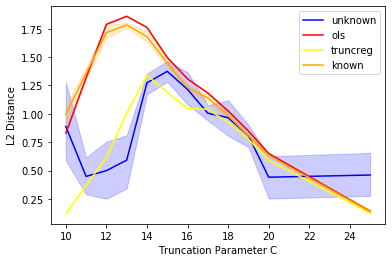

In [209]:
# plot results for regression parameter MSE
sns.lineplot(data=unknown_logs, x='c', y='unknown_param_mse', label='unknown', color='blue')
sns.lineplot(data=logs, x='c', y='ols_param_mse', label='ols', color='red')
sns.lineplot(data=truncreg_logs, x='c', y='trunc_reg_param_mse', label='truncreg', color='yellow')
ax = sns.lineplot(data=known_logs, x='c', y='known_param_mse', label='known', color='orange')
ax.set(xlabel='Truncation Parameter C', ylabel='L2 Distance')
plt.show()

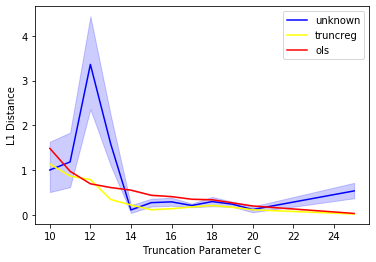

In [210]:
# plot results for regression noise variance MSE
sns.lineplot(data=unknown_logs, x='c', y='unknown_var_l1', label='unknown', color="blue")
sns.lineplot(data=truncreg_logs, x='c', y='trunc_reg_var_l1', label='truncreg', color='yellow')
ax = sns.lineplot(data=logs, x='c', y='ols_var_l1', label='ols', color="red")
ax.set(xlabel='Truncation Parameter C', ylabel='L1 Distance')
# ax.set(ylim=(0, .05))
plt.show()

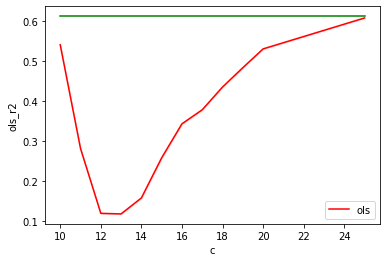

In [21]:
# plot results for regression parameter MSE
# sns.lineplot(data=logs, x='c', y='unknown_r2', label='unknown', color='blue')
sns.lineplot(data=logs, x='c', y='ols_r2', label='ols', color='red')
# sns.lineplot(data=logs, x='c', y='trunc_reg_r2', label='truncreg', color='yellow')
plt.plot(C, [gt_r2]*len(C), label='gt', color='green')
# ax = sns.lineplot(data=logs, x='c', y='known_r2', label='known', color='orange')
ax.set(xlabel='Truncation Parameter C', ylabel='R2')
plt.show()

In [30]:
trunc_reg.score()

tensor(0.0427, grad_fn=<CopyBackwards>)

In [559]:
gt_var

tensor([1033.5864])

In [560]:
emp_noise_var

tensor([[84.9927]])

In [561]:
known_params

tensor([5.9732e-03, 4.2906e-02, 5.9897e+01])

In [562]:
gt_params

tensor([ -0.0697,   0.2125, -22.8026])

In [563]:
ols_params

tensor([-2.5557e-03,  3.7274e-02,  9.1479e+00])

In [571]:
unknown_trunc_reg.weight.size()

torch.Size([2, 1])

In [42]:
gt_r2

0.5411531520066606

In [57]:
trunc_reg.variance * emp_noise_var 

tensor([[219.6276]])

In [24]:
unknown_params

tensor([-0.0762,  0.1870, 37.4407])

In [25]:
gt_params

tensor([-0.1166,  0.2347, 58.3021])

In [26]:
ols_params

tensor([-0.0484,  0.1163, 46.0508])

In [27]:
known_params

tensor([-4.7087e-02,  1.1756e-01,  5.3071e+01])